In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

## Try new data

In [8]:
df_new = pd.read_parquet('../data/processed/preprocessed_prophet.parquet')
df_new.dropna(inplace = True)
df_new.head()

mempool_blocks_blockSize  mempool_blocks_blockVSize  \
timestamp                                                                  
2025-03-05 02:00:00              2.170952e+06              997895.375000   
2025-03-05 02:15:00              1.801526e+06              997925.916667   
2025-03-05 02:30:00              2.055350e+06              997965.916667   
2025-03-05 02:45:00              2.006800e+06              997970.083333   
2025-03-05 03:00:00              1.773658e+06              997960.333333   

                     mempool_blocks_nTx  mempool_blocks_totalFees  \
timestamp                                                           
2025-03-05 02:00:00          793.000000              1.846754e+06   
2025-03-05 02:15:00         2627.000000              3.407913e+06   
2025-03-05 02:30:00          922.000000              1.855358e+06   
2025-03-05 02:45:00         1296.666667              2.167251e+06   
2025-03-05 03:00:00         2725.333333              3.462741e+06   

                     mempool_blocks_medianFee  recommended_fee_fastestFee  \
timestamp                                                                   
2025-03-05 02:00:00                  1.300111                    2.000000   
2025-03-05 02:15:00                  2.473960                    3.000000   
2025-03-05 02:30:00                  1.355898                    2.000000   
2025-03-05 02:45:00                  1.536092                    2.333333   
2025-03-05 03:00:00                  2.467659                    3.333333   

                     recommended_fee_halfHourFee  recommended_fee_hourFee  \
timestamp                                                                   
2025-03-05 02:00:00                     2.000000                 2.000000   
2025-03-05 02:15:00                     2.666667                 2.666667   
2025-03-05 02:30:00                     2.000000                 2.000000   
2025-03-05 02:45:00                     2.333333                 2.333333   
2025-03-05 03:00:00                     3.000000                 3.000000   

                     recommended_fee_economyFee  recommended_fee_minimumFee  \
timestamp                                                                     
2025-03-05 02:00:00                    2.000000                         2.0   
2025-03-05 02:15:00                    2.666667                         2.0   
2025-03-05 02:30:00                    2.000000                         2.0   
2025-03-05 02:45:00                    2.333333                         2.0   
2025-03-05 03:00:00                    3.000000                         2.0   

                     ...  mempool_fee_histogram_bin_70_75  \
timestamp            ...                                    
2025-03-05 02:00:00  ...                              0.0   
2025-03-05 02:15:00  ...                              0.0   
2025-03-05 02:30:00  ...                              0.0   
2025-03-05 02:45:00  ...                              0.0   
2025-03-05 03:00:00  ...                              0.0   

                     mempool_fee_histogram_bin_75_80  \
timestamp                                              
2025-03-05 02:00:00                              0.0   
2025-03-05 02:15:00                              0.0   
2025-03-05 02:30:00                              0.0   
2025-03-05 02:45:00                              0.0   
2025-03-05 03:00:00                              0.0   

                     mempool_fee_histogram_bin_80_85  \
timestamp                                              
2025-03-05 02:00:00                              0.0   
2025-03-05 02:15:00                              0.0   
2025-03-05 02:30:00                              0.0   
2025-03-05 02:45:00                              0.0   
2025-03-05 03:00:00                              0.0   

                     mempool_fee_histogram_bin_85_90  \
timestamp                                              
2025-03-05 02:00:00                         

In [9]:
y_new = df_new["recommended_fee_fastestFee"]
X_new = df_new.drop(columns = "recommended_fee_fastestFee")
X_new = X_new.reset_index()
X_new = X_new.drop(columns = "timestamp")

# last 24h as test
split_index = len(X_new) - 96

X_train_new, X_test_new = X_new.iloc[:split_index], X_new.iloc[split_index:]
y_train_new, y_test_new = y_new.iloc[:split_index], y_new.iloc[split_index:]


In [10]:
df_prophet_new = y_train_new.reset_index()
df_prophet_new = df_prophet_new.rename(columns={
    'timestamp': 'ds',
    'recommended_fee_fastestFee': 'y'
})
df_prophet_new['y'] = np.log1p(df_prophet_new['y'])
df_prophet_new.head()

ds         y
0 2025-03-05 02:00:00  1.098612
1 2025-03-05 02:15:00  1.386294
2 2025-03-05 02:30:00  1.098612
3 2025-03-05 02:45:00  1.203973
4 2025-03-05 03:00:00  1.466337

In [13]:
def get_result_new(df,y_test,y):
    df.index = y.index
    y_pred = df.iloc[-96:]
    y_pred = np.expm1(y_pred["yhat"])
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    result_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    }, index=y_test.index)

    plt.figure(figsize=(14, 5))
    sns.lineplot(data=result_df)
    plt.title('Predicted vs Actual Fee Rates')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Fee rate (sats/vByte)')
    plt.legend(['Actual', 'Predicted'])
    plt.tight_layout()
    plt.show()

## Optimization - Find the best params

In [12]:
results = [] 

for params in all_params:
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        **params
    )
    m.add_seasonality(name='hourly', period=1/24, fourier_order=6)
    m.add_seasonality(name='daily', period=1, fourier_order=8)
    m.add_seasonality(name='weekly', period=7, fourier_order=4)
    
    m.fit(df_prophet_new)
    df_cv = cross_validation(m, initial='7 days', period='1 day', horizon='1 day', parallel="processes")
    df_p = performance_metrics(df_cv)
    
    results.append((params, df_p['rmse'].mean()))
print("Done")

13:45:49 - cmdstanpy - INFO - Chain [1] start processing
13:45:50 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [1] done processing
13:45:51 - cmdstanpy - INFO - Chain [

Done


17:22:51 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
best_params = sorted(results, key=lambda x: x[1])[0]
print(f"Best params：{best_params[0]}\nRMSE：{best_params[1]:.4f}")

Best params：{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9, 'n_changepoints': 100}
RMSE：0.3382


In [15]:
def create_model_new():
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale = 0.01,
        seasonality_prior_scale=20.0,
        seasonality_mode='multiplicative',
        changepoint_range=0.9,
        n_changepoints=100
    )
    model.add_seasonality(name='hourly', period=1/24, fourier_order=5) 
    model.add_seasonality(name='daily', period=1, fourier_order=10)  
    model.add_seasonality(name='weekly', period=24, fourier_order=5) 

    return model


17:40:26 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing


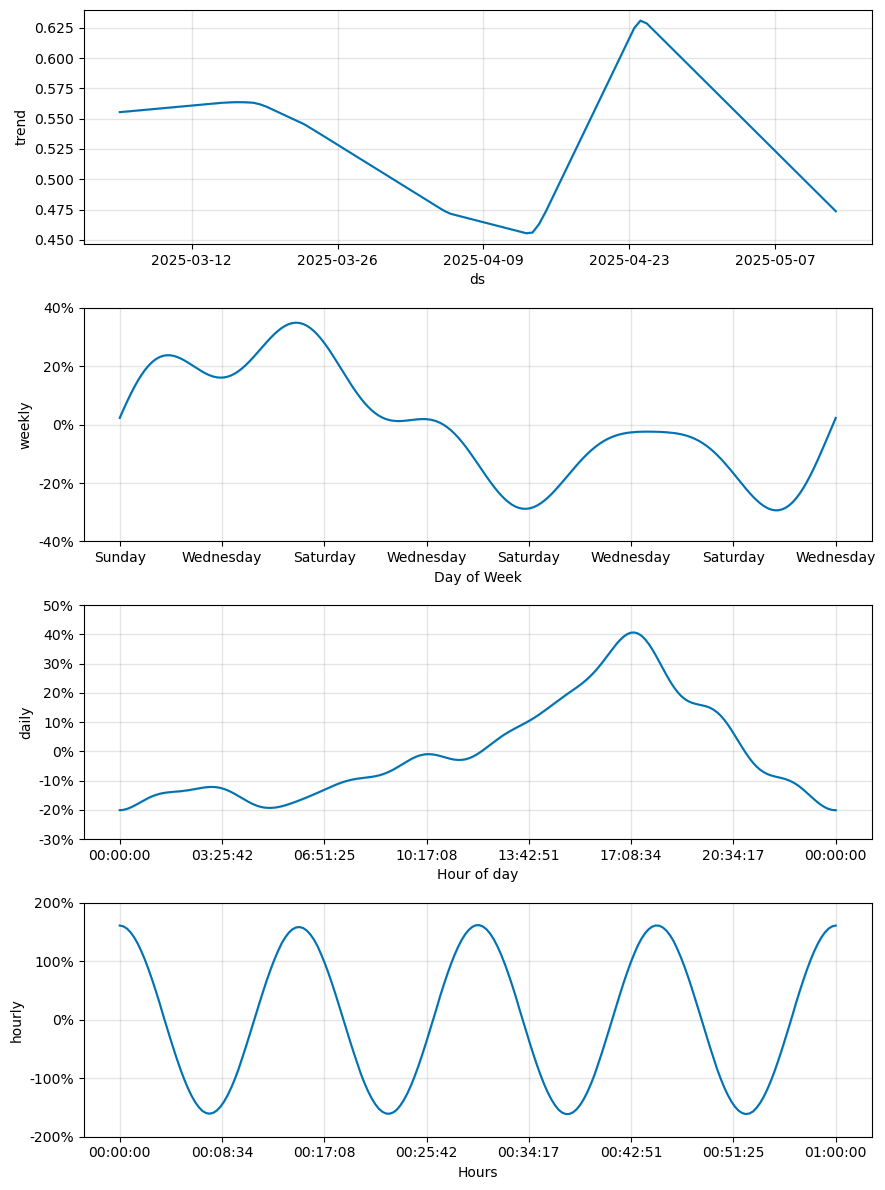

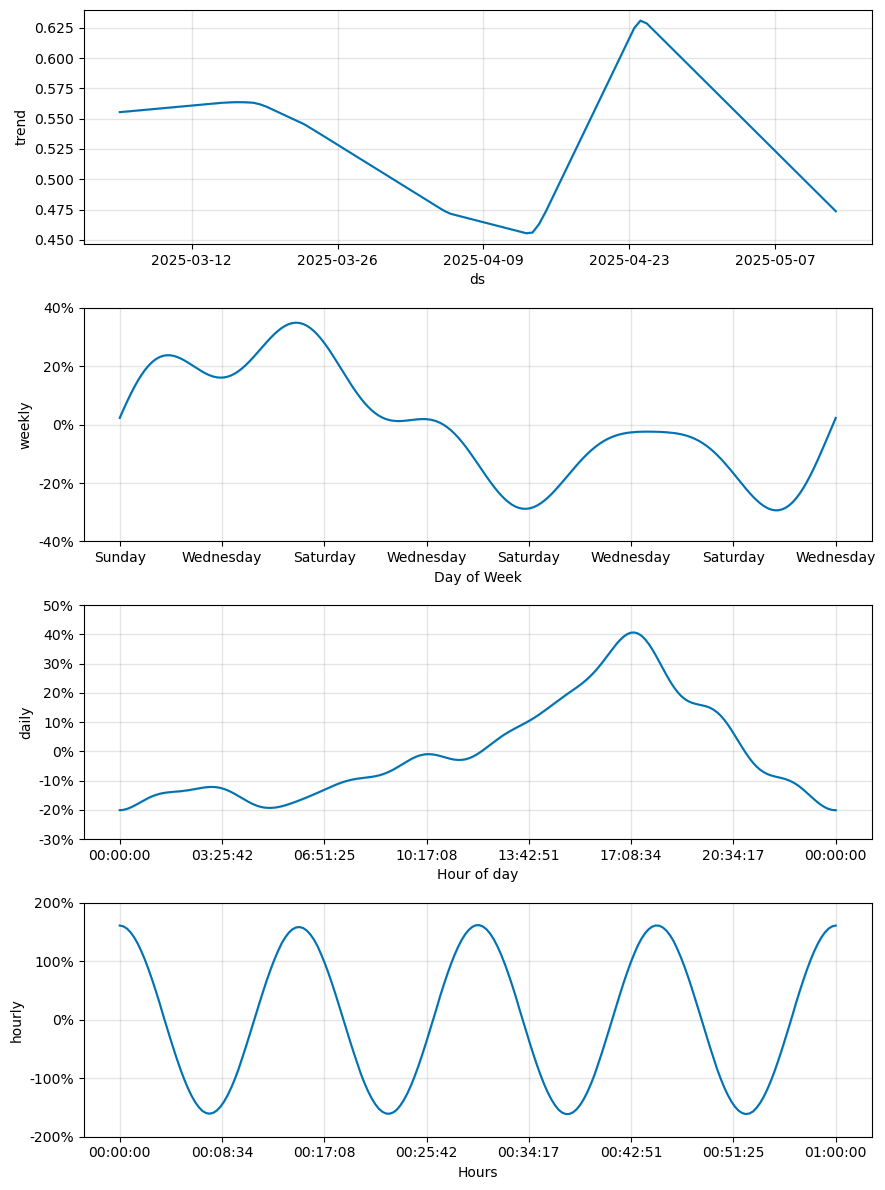

In [16]:
model = create_model_new()
model.fit(df_prophet_new)
future = model.make_future_dataframe(periods=96, freq='15min')
forecast = model.predict(future)
model.plot_components(forecast)

MAE: 5.4135
RMSE: 11.7835
MAPE: 0.6244


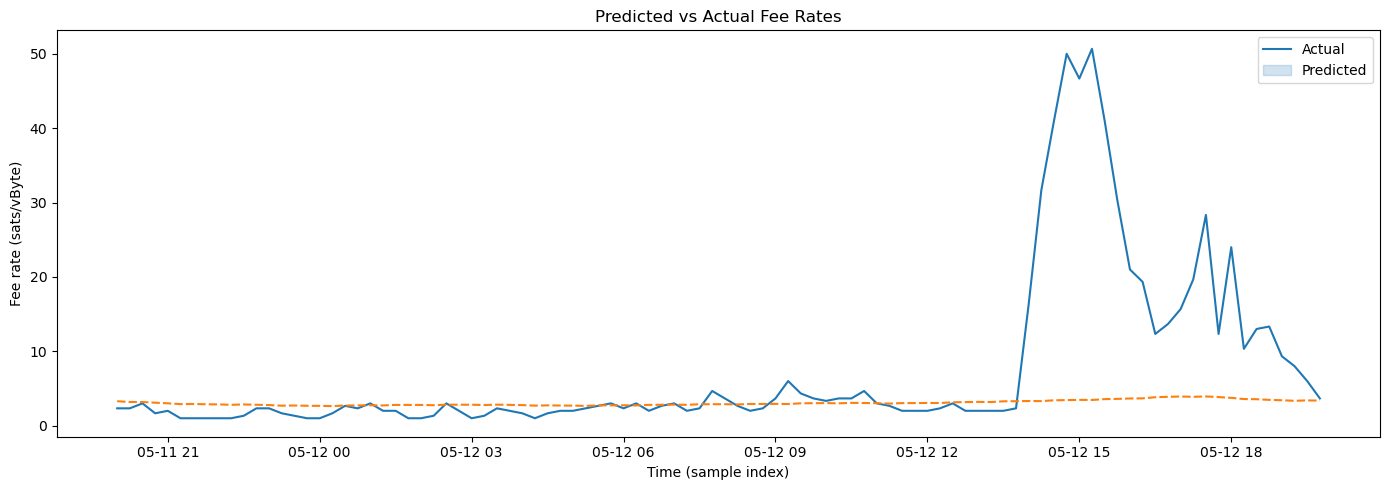

In [18]:
get_result_new(forecast,y_test_new,y_new)

20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing


Week 1
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
MAE: 1.5384
RMSE: 2.2068
MAPE: 0.4079


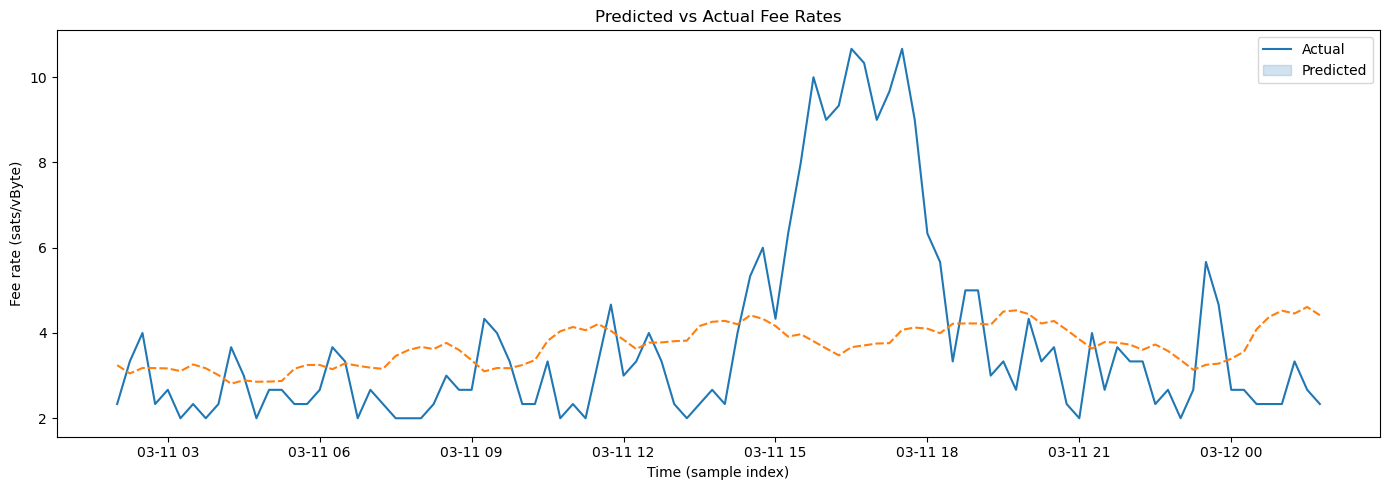

Week 2


20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
MAE: 0.7370
RMSE: 0.9613
MAPE: 0.2823


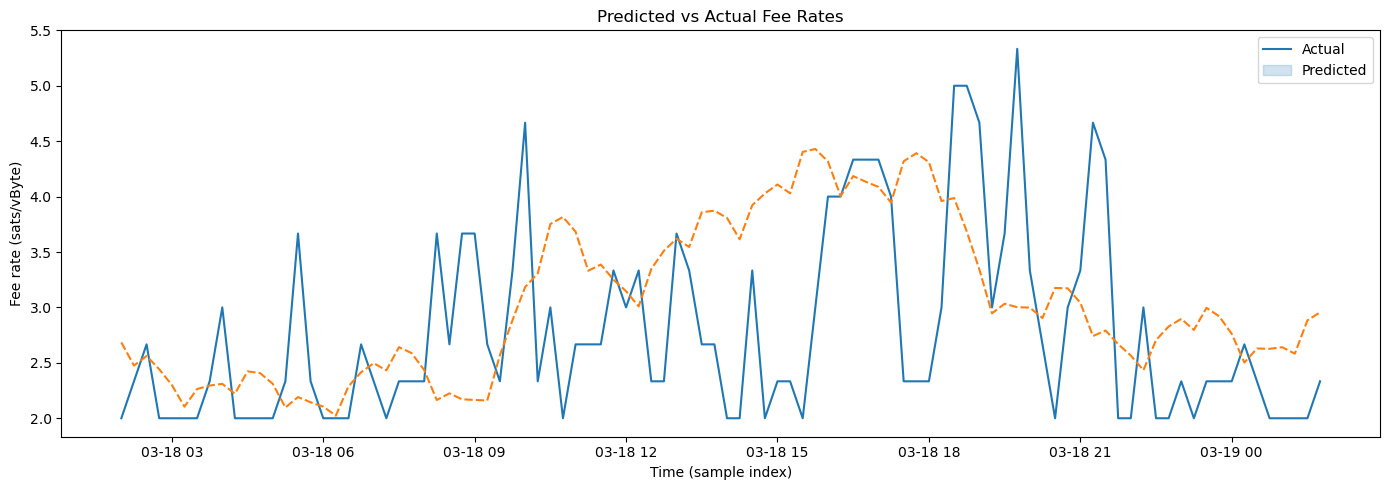

Week 3


20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 5.3958
Baseline RMSE: 10.4472
Baseline MAPE: 0.4088
MAE: 5.1268
RMSE: 9.4317
MAPE: 0.5774


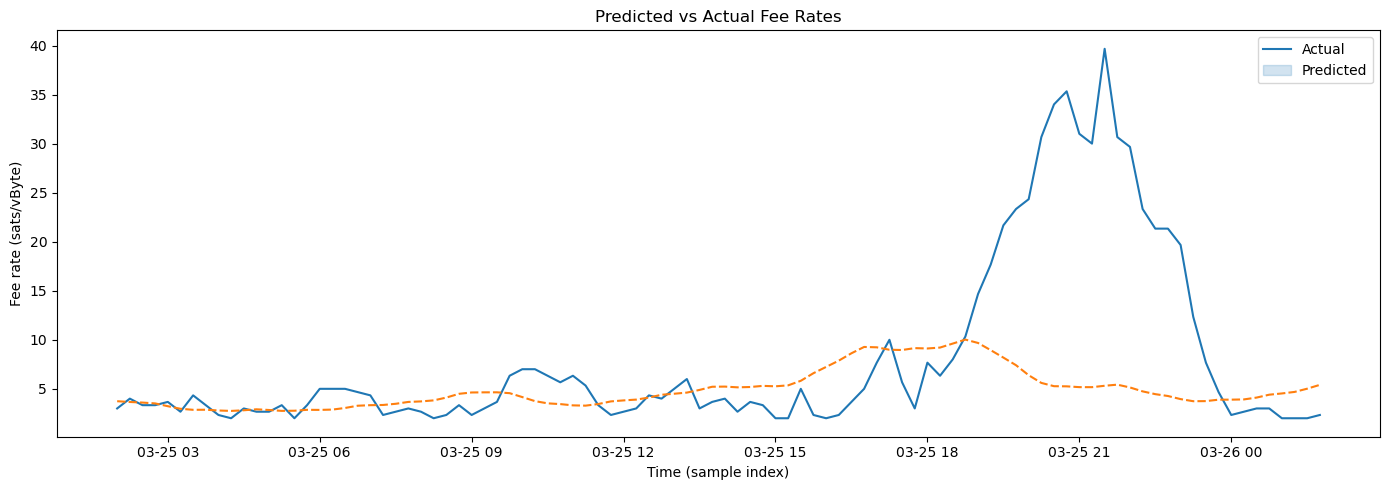

20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing


Week 4
Baseline MAE: 0.8264
Baseline RMSE: 0.9682
Baseline MAPE: 0.4462
MAE: 1.4993
RMSE: 1.8466
MAPE: 0.9061


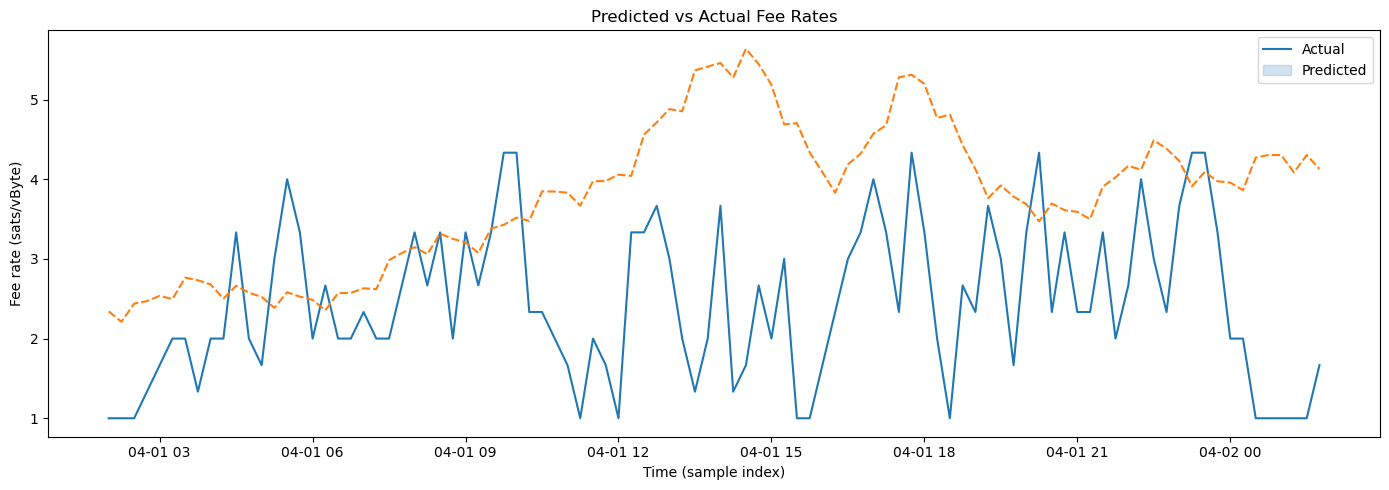

20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:02 - cmdstanpy - INFO - Chain [1] done processing


Week 5
Baseline MAE: 1.2361
Baseline RMSE: 1.6618
Baseline MAPE: 0.5004
MAE: 1.2255
RMSE: 1.6130
MAPE: 0.5682


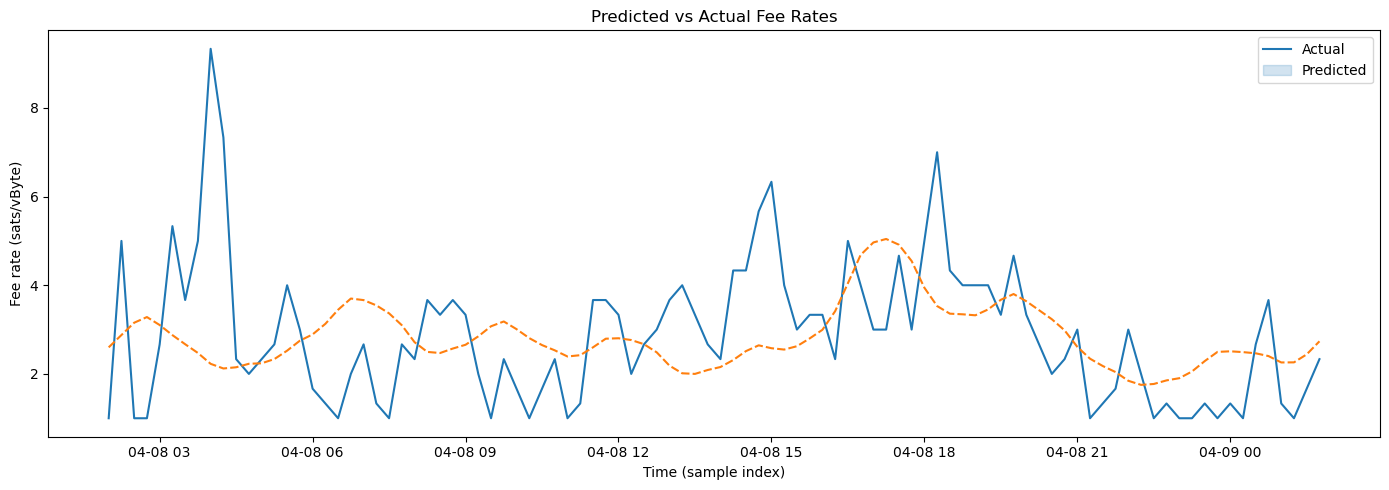

Week 6


20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:02 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 1.0174
Baseline RMSE: 1.3484
Baseline MAPE: 0.3554
MAE: 1.0232
RMSE: 1.3002
MAPE: 0.3727


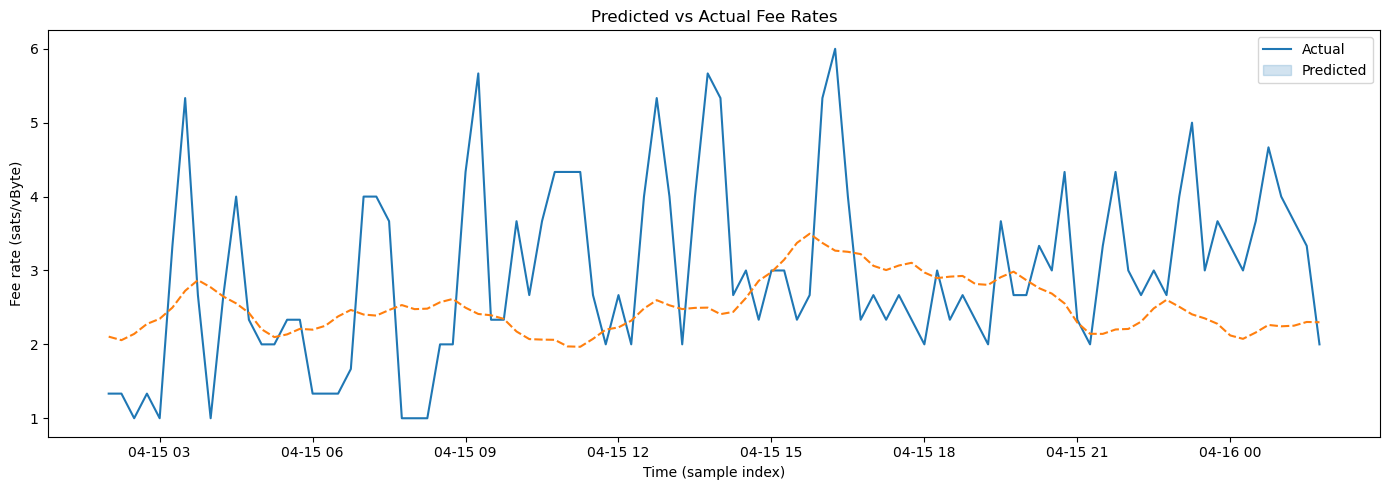

20:49:02 - cmdstanpy - INFO - Chain [1] start processing


Week 7


20:49:02 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 0.8715
Baseline RMSE: 1.0892
Baseline MAPE: 0.2773
MAE: 0.9197
RMSE: 1.0960
MAPE: 0.3159


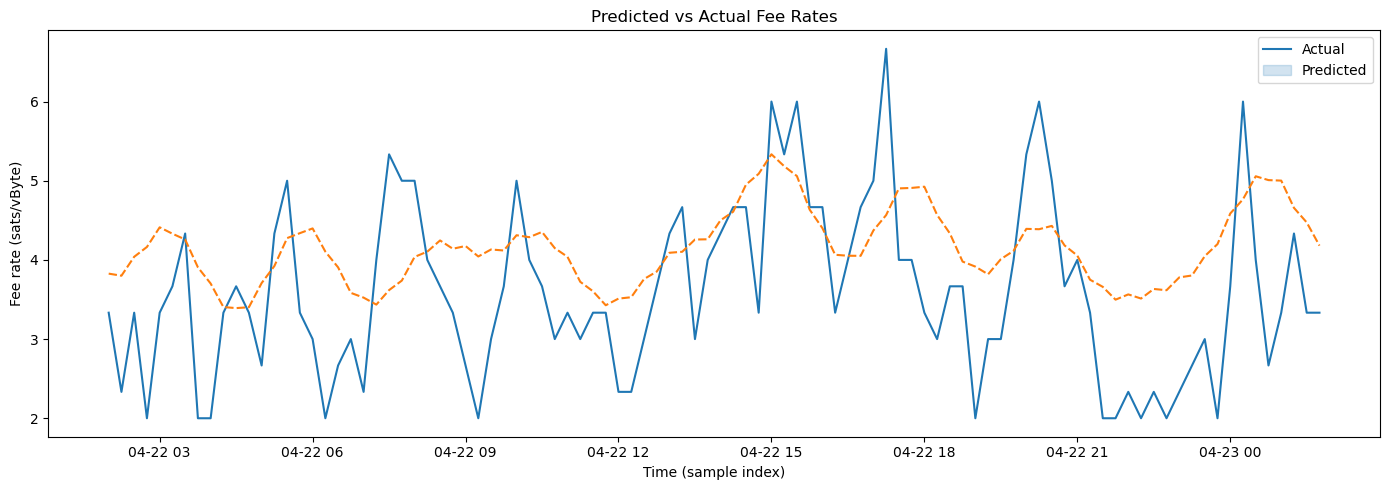

20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:02 - cmdstanpy - INFO - Chain [1] done processing


Week 8
Baseline MAE: 0.8438
Baseline RMSE: 1.0924
Baseline MAPE: 0.2407
MAE: 1.0890
RMSE: 1.3471
MAPE: 0.2966


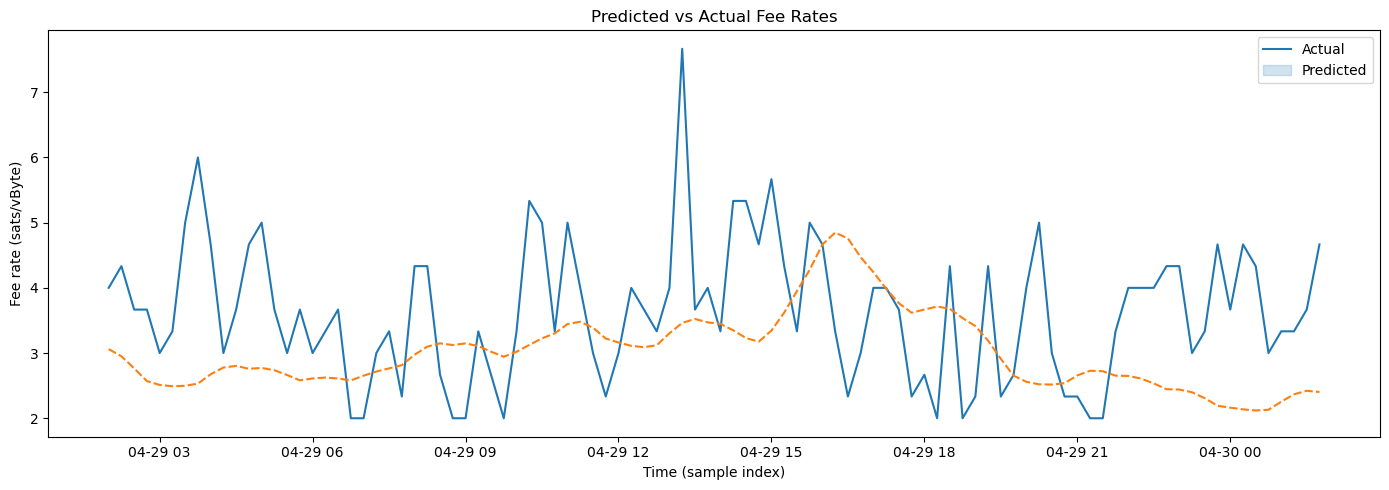

Week 9


20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:02 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 1.1042
Baseline RMSE: 1.4369
Baseline MAPE: 0.3126
MAE: 0.9377
RMSE: 1.2404
MAPE: 0.2752


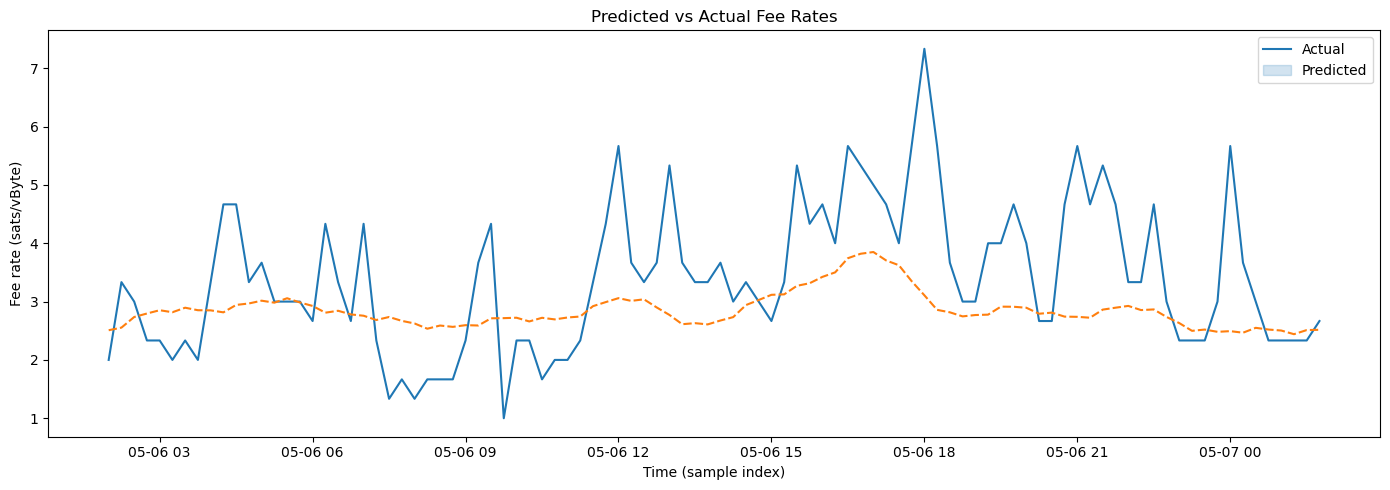

20:49:03 - cmdstanpy - INFO - Chain [1] start processing
20:49:03 - cmdstanpy - INFO - Chain [1] done processing


Week 10
Baseline MAE: 5.6146
Baseline RMSE: 12.0169
Baseline MAPE: 0.6775
MAE: 5.7741
RMSE: 12.5049
MAPE: 0.4891


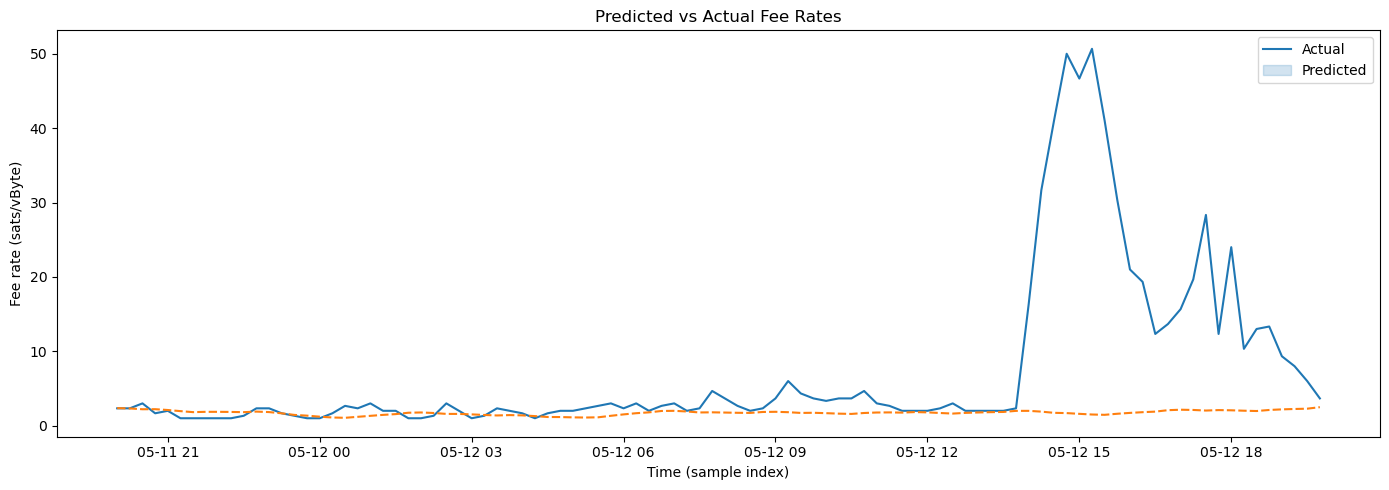



Average values: 
MAE: 1.9871
RMSE: 3.3548
MAPE: 0.4491
Baseline MAE: 1.9003
Baseline RMSE: 3.3423
Baseline MAPE: 0.3717


In [48]:
avg_mae = 0
avg_rmse = 0
avg_mape = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0

## Week 1 to Week 10
for i in range(10):
    print("Week",(i+1))
    df_sliding = df_new[0+i*7*96:7*96+i*7*96]
    y = df_sliding["recommended_fee_fastestFee"]
    split_index = len(y) - 96
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    df_prophet = y_train.reset_index()
    df_prophet = df_prophet.rename(columns={
        'timestamp': 'ds',
        'recommended_fee_fastestFee': 'y'
    })
    df_prophet['y'] = np.log1p(df_prophet['y'])

    # baseline
    y_baseline = [y_train.median()] * len(y_test)

    model = create_model_new()
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=96, freq='15min')
    forecast = model.predict(future)

    y_pred_temp = forecast.iloc[-96:]
    y_pred_temp = np.expm1(y_pred_temp["yhat"])
    y_pred_temp.index =X_test.index

    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    
    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    get_result_new(forecast,y_test,y)



avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")

In [34]:
df_prophet_new.head()

ds         y
0 2025-03-05 02:00:00  1.098612
1 2025-03-05 02:15:00  1.386294
2 2025-03-05 02:30:00  1.098612
3 2025-03-05 02:45:00  1.203973
4 2025-03-05 03:00:00  1.466337

In [37]:
y_train_new.head()

timestamp
2025-03-05 02:00:00    2.000000
2025-03-05 02:15:00    3.000000
2025-03-05 02:30:00    2.000000
2025-03-05 02:45:00    2.333333
2025-03-05 03:00:00    3.333333
Name: recommended_fee_fastestFee, dtype: float64

## Add external features

23:09:44 - cmdstanpy - INFO - Chain [1] start processing
23:09:44 - cmdstanpy - INFO - Chain [1] done processing


Week 1
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
MAE: 1.7040
RMSE: 2.2421
MAPE: 0.5101


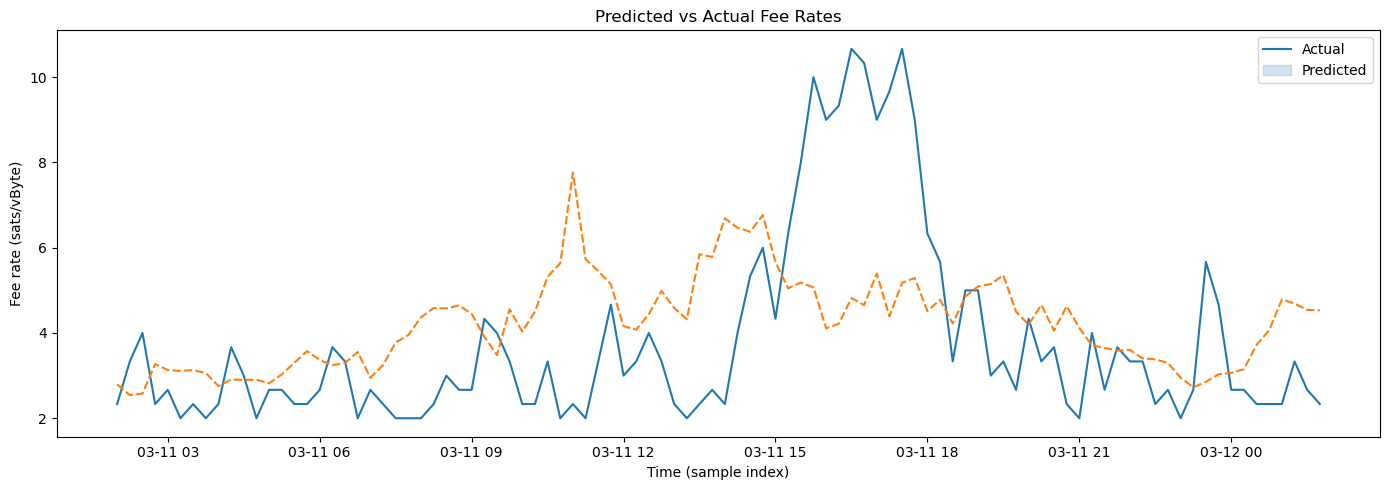

23:09:44 - cmdstanpy - INFO - Chain [1] start processing
23:09:44 - cmdstanpy - INFO - Chain [1] done processing
23:09:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:09:44 - cmdstanpy - INFO - Chain [1] start processing


Week 2


23:09:49 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
MAE: 1.1111
RMSE: 1.3670
MAPE: 0.4476


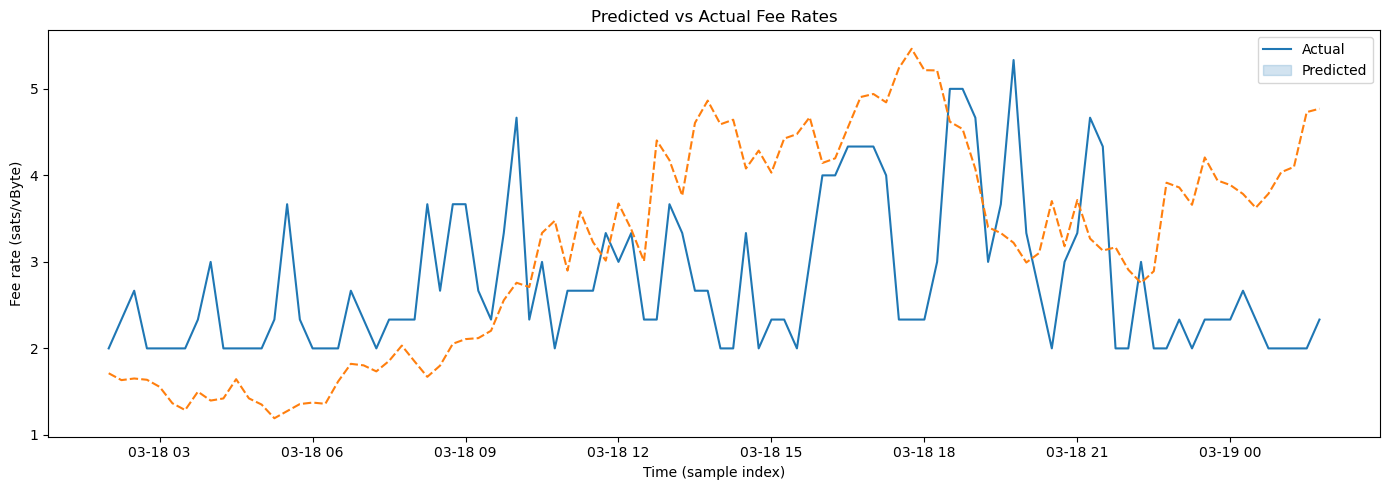

23:09:49 - cmdstanpy - INFO - Chain [1] start processing
23:09:49 - cmdstanpy - INFO - Chain [1] done processing


Week 3
Baseline MAE: 5.3958
Baseline RMSE: 10.4472
Baseline MAPE: 0.4088
MAE: 5.3061
RMSE: 9.7545
MAPE: 0.4964


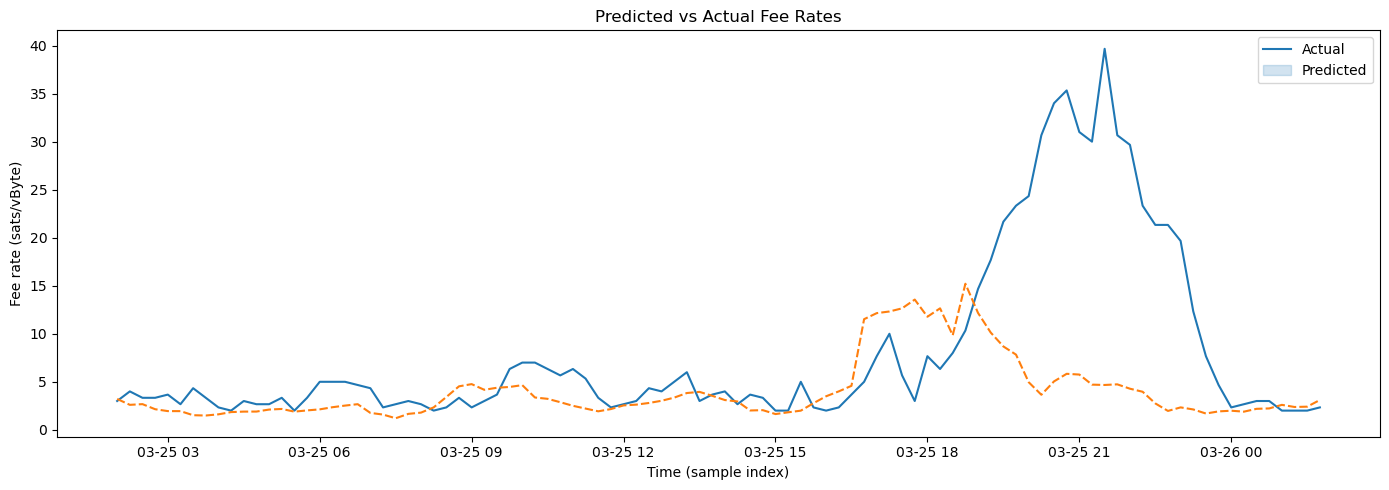

23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing
23:09:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:09:50 - cmdstanpy - INFO - Chain [1] start processing


Week 4


23:10:07 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 0.8021
Baseline RMSE: 0.9724
Baseline MAPE: 0.4068
MAE: 3.4410
RMSE: 3.5741
MAPE: 1.4941


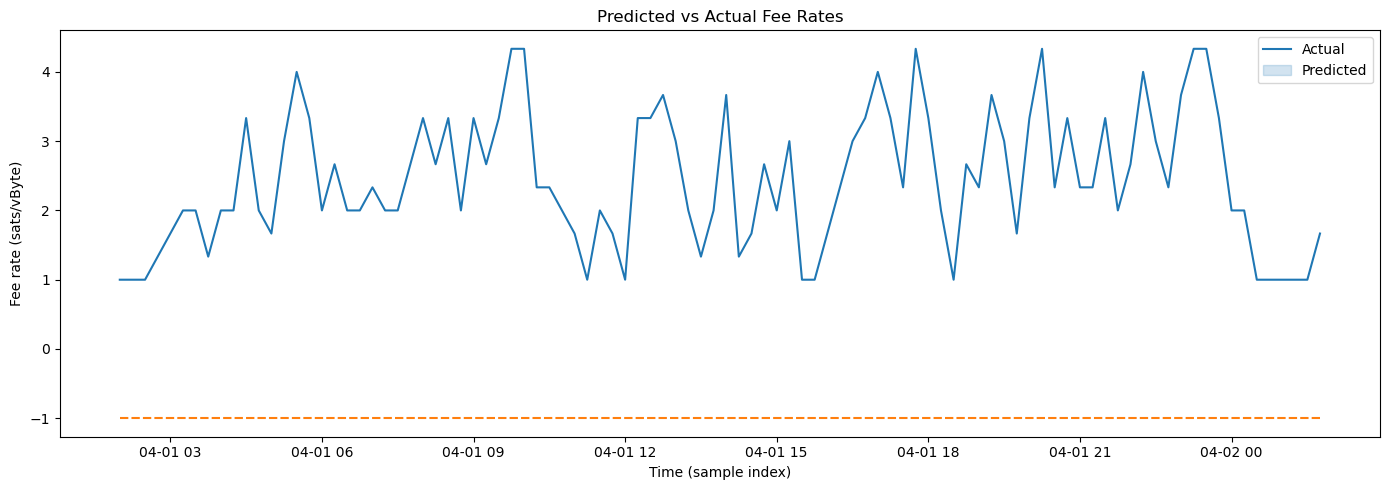

23:10:07 - cmdstanpy - INFO - Chain [1] start processing
23:10:07 - cmdstanpy - INFO - Chain [1] done processing


Week 5
Baseline MAE: 1.2361
Baseline RMSE: 1.6618
Baseline MAPE: 0.5004
MAE: 1.7361
RMSE: 2.2160
MAPE: 0.8342


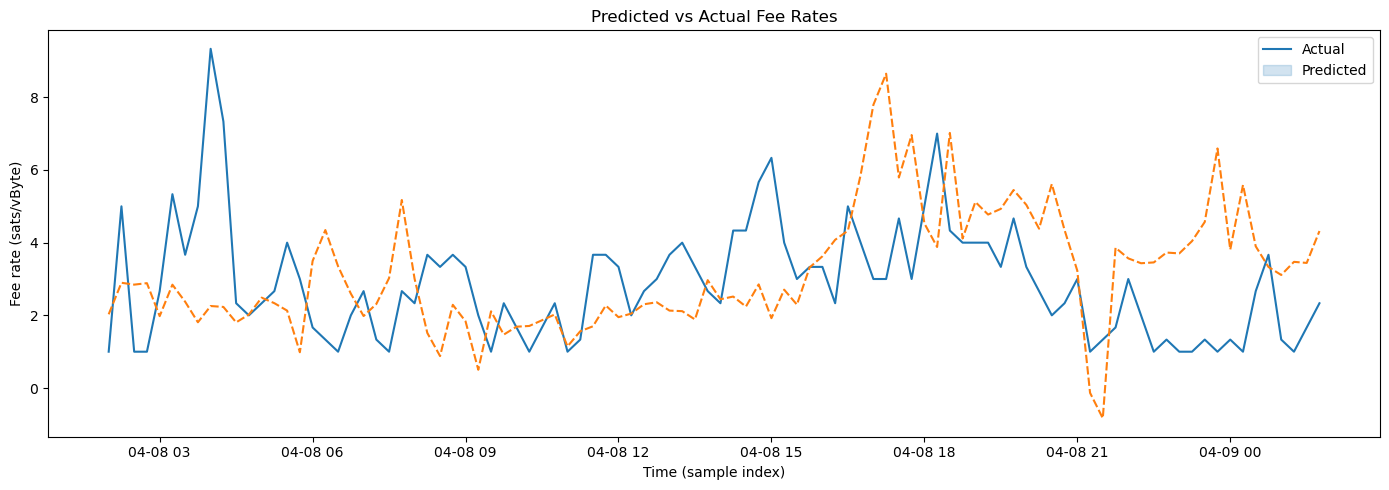

23:10:08 - cmdstanpy - INFO - Chain [1] start processing
23:10:08 - cmdstanpy - INFO - Chain [1] done processing
23:10:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:10:08 - cmdstanpy - INFO - Chain [1] start processing


Week 6


23:10:22 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 1.0174
Baseline RMSE: 1.3484
Baseline MAPE: 0.3554
MAE: 3660.0422
RMSE: 14528.9437
MAPE: 1265.4268


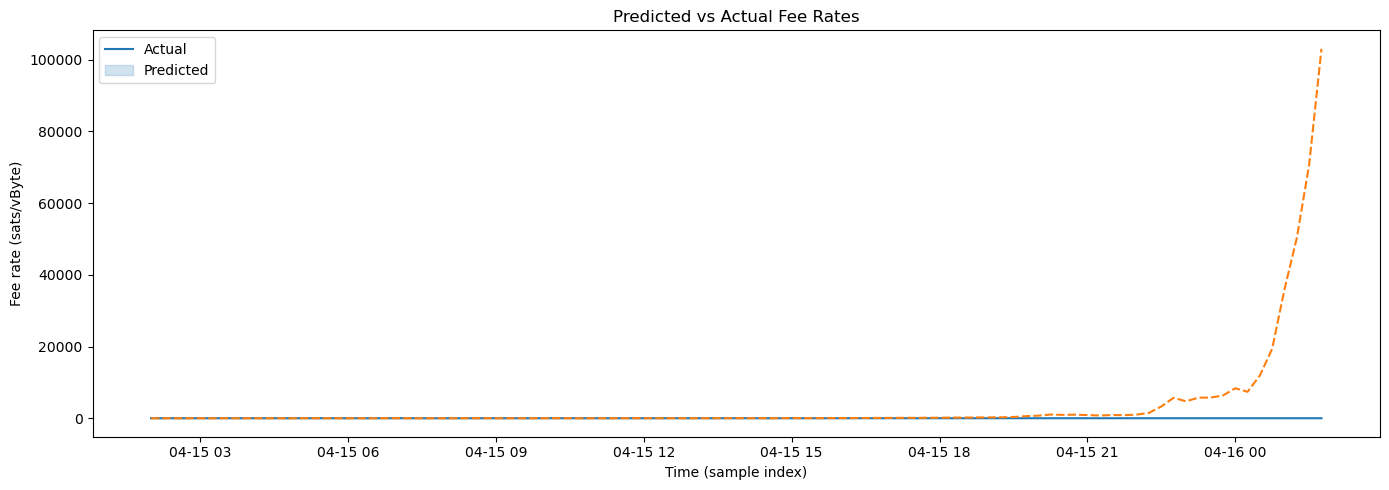

23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing


Week 7
Baseline MAE: 0.8715
Baseline RMSE: 1.0892
Baseline MAPE: 0.2773
MAE: 1.1183
RMSE: 1.3973
MAPE: 0.3788


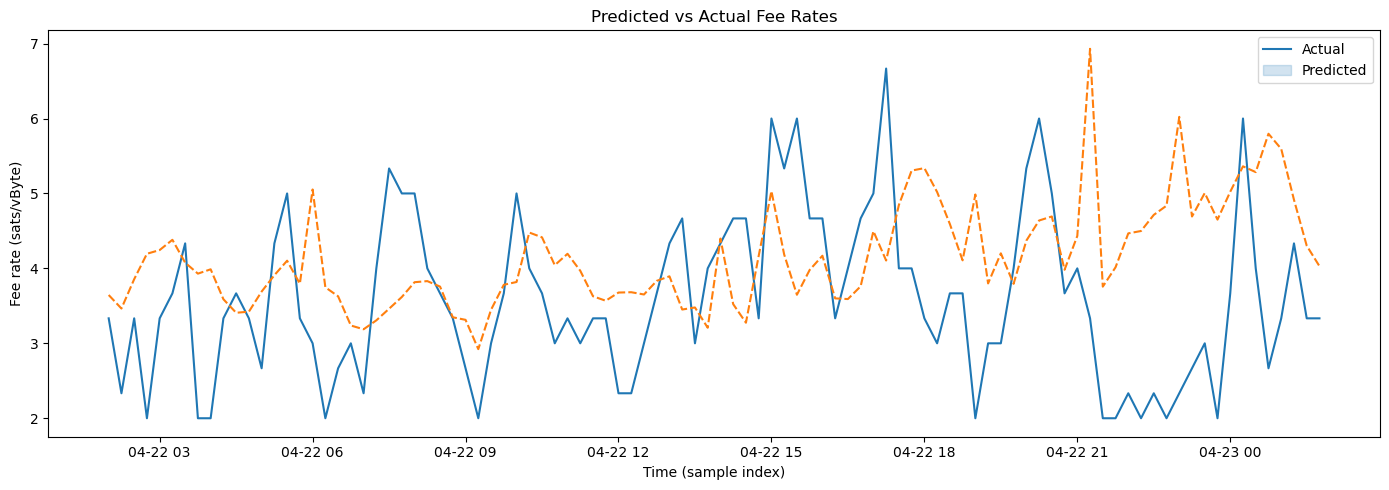

23:10:23 - cmdstanpy - INFO - Chain [1] start processing
23:10:23 - cmdstanpy - INFO - Chain [1] done processing
23:10:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:10:23 - cmdstanpy - INFO - Chain [1] start processing


Week 8


23:12:11 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 0.8438
Baseline RMSE: 1.0924
Baseline MAPE: 0.2407
MAE: 1660490787264871471764133441784078016458207554057535488.0000
RMSE: 4982471452695560098300427658292766318876123426149367808.0000
MAPE: 449360755668608670081920407452211585697271906899591168.0000


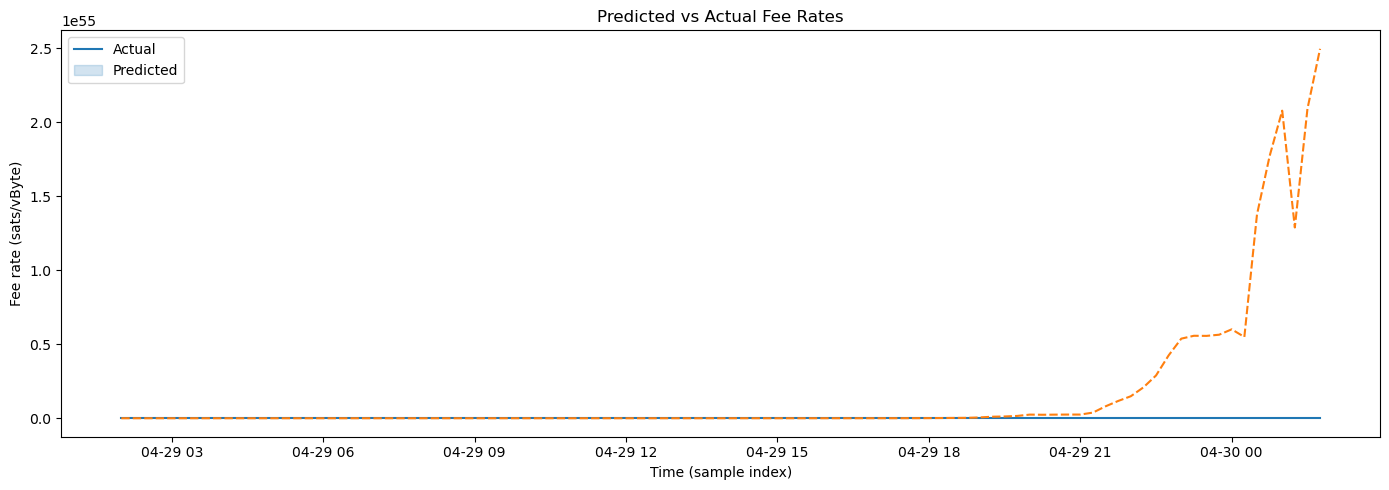

23:12:12 - cmdstanpy - INFO - Chain [1] start processing


Week 9


23:12:12 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 1.1042
Baseline RMSE: 1.4369
Baseline MAPE: 0.3126
MAE: 1.0578
RMSE: 1.3613
MAPE: 0.3026


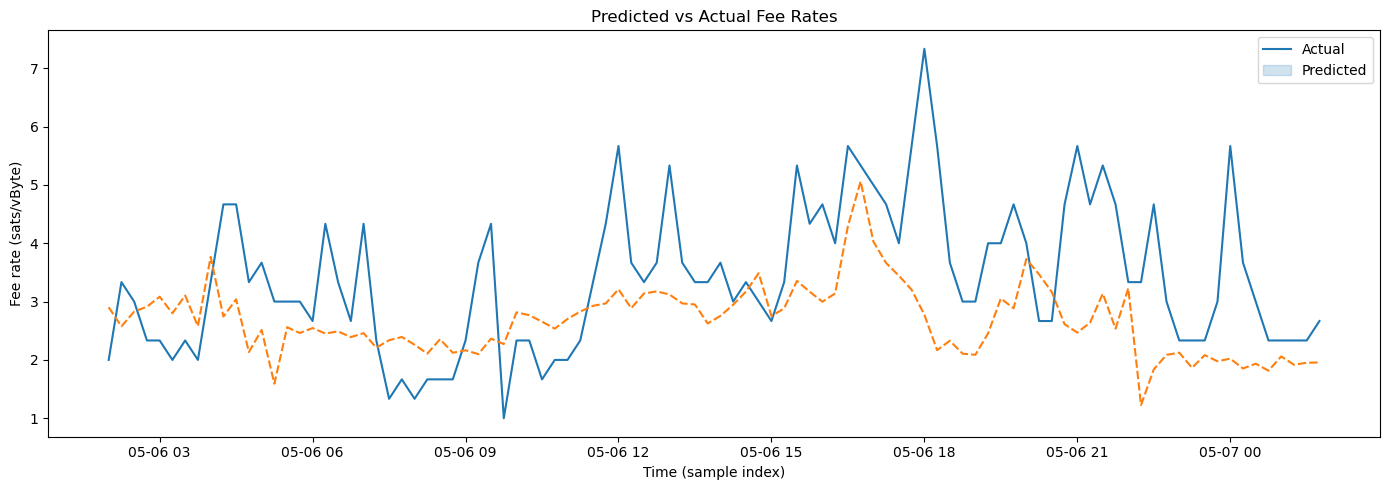

23:12:12 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing
23:12:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:12:12 - cmdstanpy - INFO - Chain [1] start processing


Week 10


23:13:06 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 5.6146
Baseline RMSE: 12.0169
Baseline MAPE: 0.6775
MAE: 8.3229
RMSE: 13.9639
MAPE: 1.4100


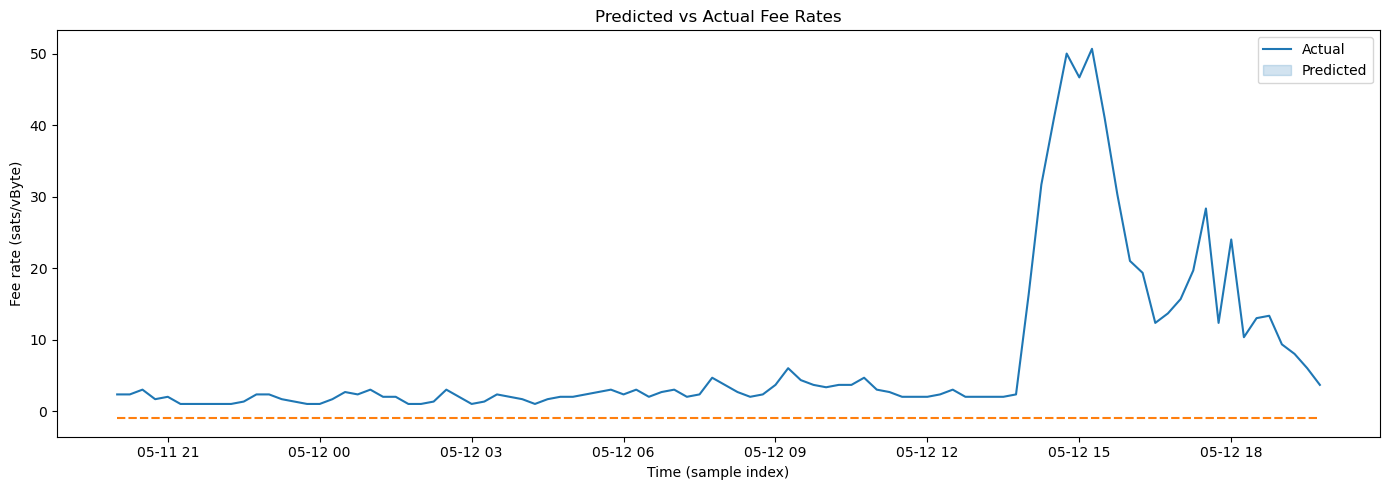



Average values: 
MAE: 166049078726487151429942930690138594938003348302856192.0000
RMSE: 498247145269555992815924419782353458718881971026526208.0000
MAPE: 44936075566860865944809644117288460246681542465683456.0000
Baseline MAE: 1.8979
Baseline RMSE: 3.3427
Baseline MAPE: 0.3678


In [58]:
avg_mae = 0
avg_rmse = 0
avg_mape = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0

## Week 1 to Week 10
for i in range(10):
    print("Week",(i+1))
    df_sliding = df_new[0+i*7*96:7*96+i*7*96]

    X = df_sliding.drop(columns = "recommended_fee_fastestFee")
    y = df_sliding["recommended_fee_fastestFee"]

    # shift
    shift_steps = 96 # shift 24h
    X = X.shift(periods=shift_steps)
    X.dropna(inplace=True)
    y = y.loc[X.index]

    split_index = len(y) - 96
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    df_prophet = y_train.reset_index()
    df_prophet = df_prophet.rename(columns={
        'timestamp': 'ds',
        'recommended_fee_fastestFee': 'y'
    })
    df_prophet['y'] = np.log1p(df_prophet['y'])

    # baseline
    y_baseline = [y_train.median()] * len(y_test)

    model = create_model_new()

    # add external features
    X_col = X_train.reset_index()
    X_col = X_col.drop(columns = "timestamp")
    for i in X_col.columns.values:
        df_prophet[i] = X_col[i].copy()
        model.add_regressor(i)

    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=96, freq='15min')

    # add external features
    for i in X.columns.values:
        future[i] = list(df_prophet[i]) + list(X_test[i])

    forecast = model.predict(future)

    y_pred_temp = forecast.iloc[-96:]
    y_pred_temp = np.expm1(y_pred_temp["yhat"])
    y_pred_temp.index =X_test.index

    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    
    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    get_result_new(forecast,y_test,y)



avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")

## Set holidays

In [44]:
def create_model_new_holiday(y_train):
    s = y_train.reset_index()
    threshold = s['recommended_fee_fastestFee'].quantile(0.99)
    spike_times = s[s['recommended_fee_fastestFee'] > threshold]['timestamp']

    # holidays dataframe
    holidays = pd.DataFrame({
        'ds': pd.to_datetime(spike_times),
        'holiday': 'congestion_spike'
    })

    # remove duplicate
    holidays = holidays.drop_duplicates(subset='ds')
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale = 0.01,
        seasonality_prior_scale=20.0,
        seasonality_mode='multiplicative',
        changepoint_range=0.9,
        n_changepoints=100,
        holidays=holidays
    )

    model.add_seasonality(name='hourly', period=1/24, fourier_order=5) 
    model.add_seasonality(name='daily', period=1, fourier_order=10)  
    model.add_seasonality(name='weekly', period=24, fourier_order=5) 

    return model


18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing


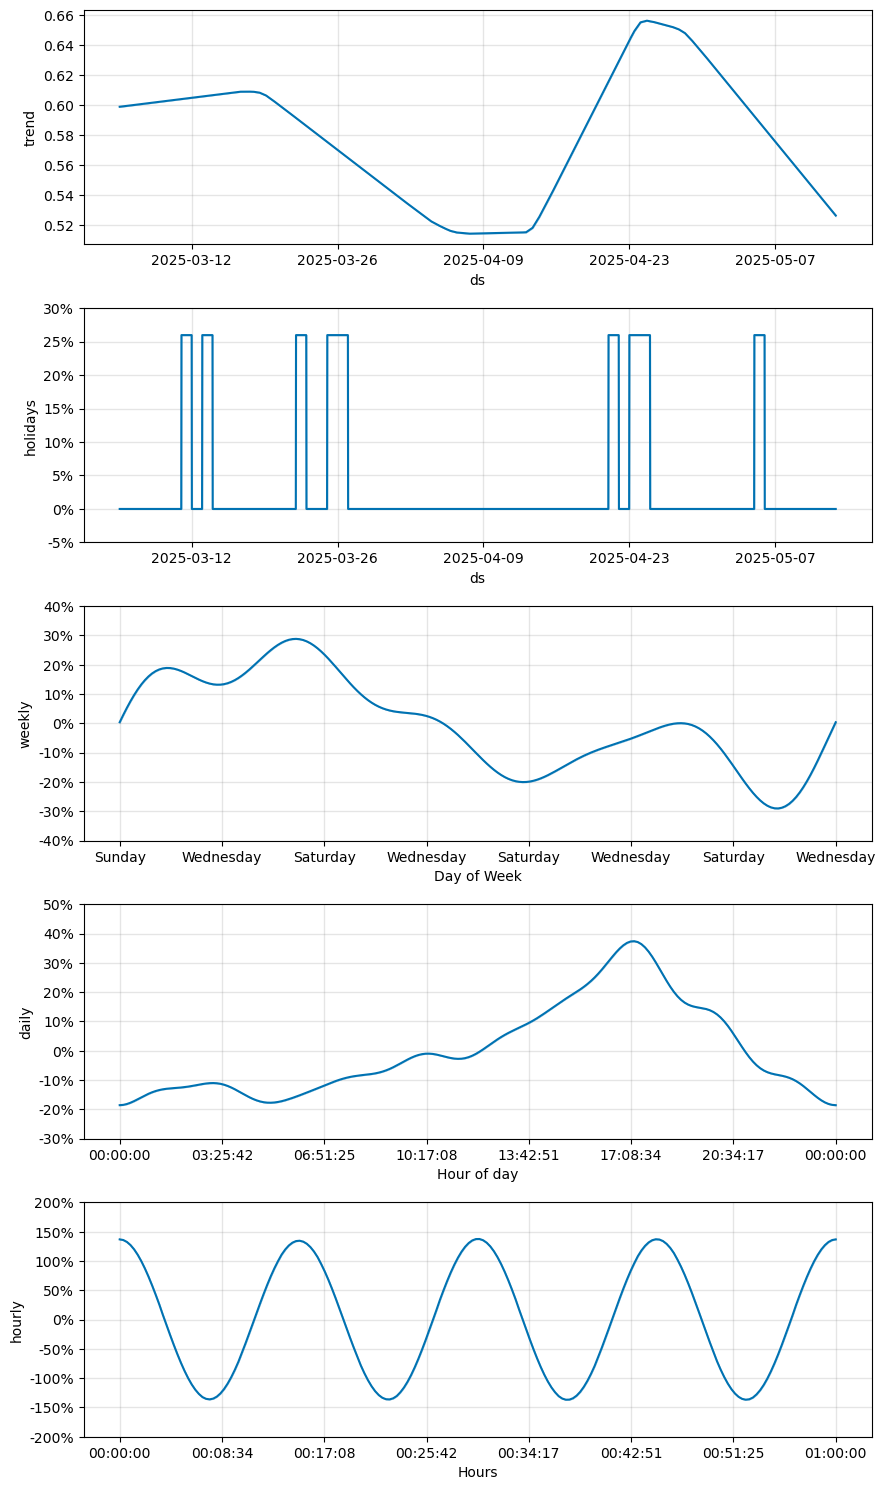

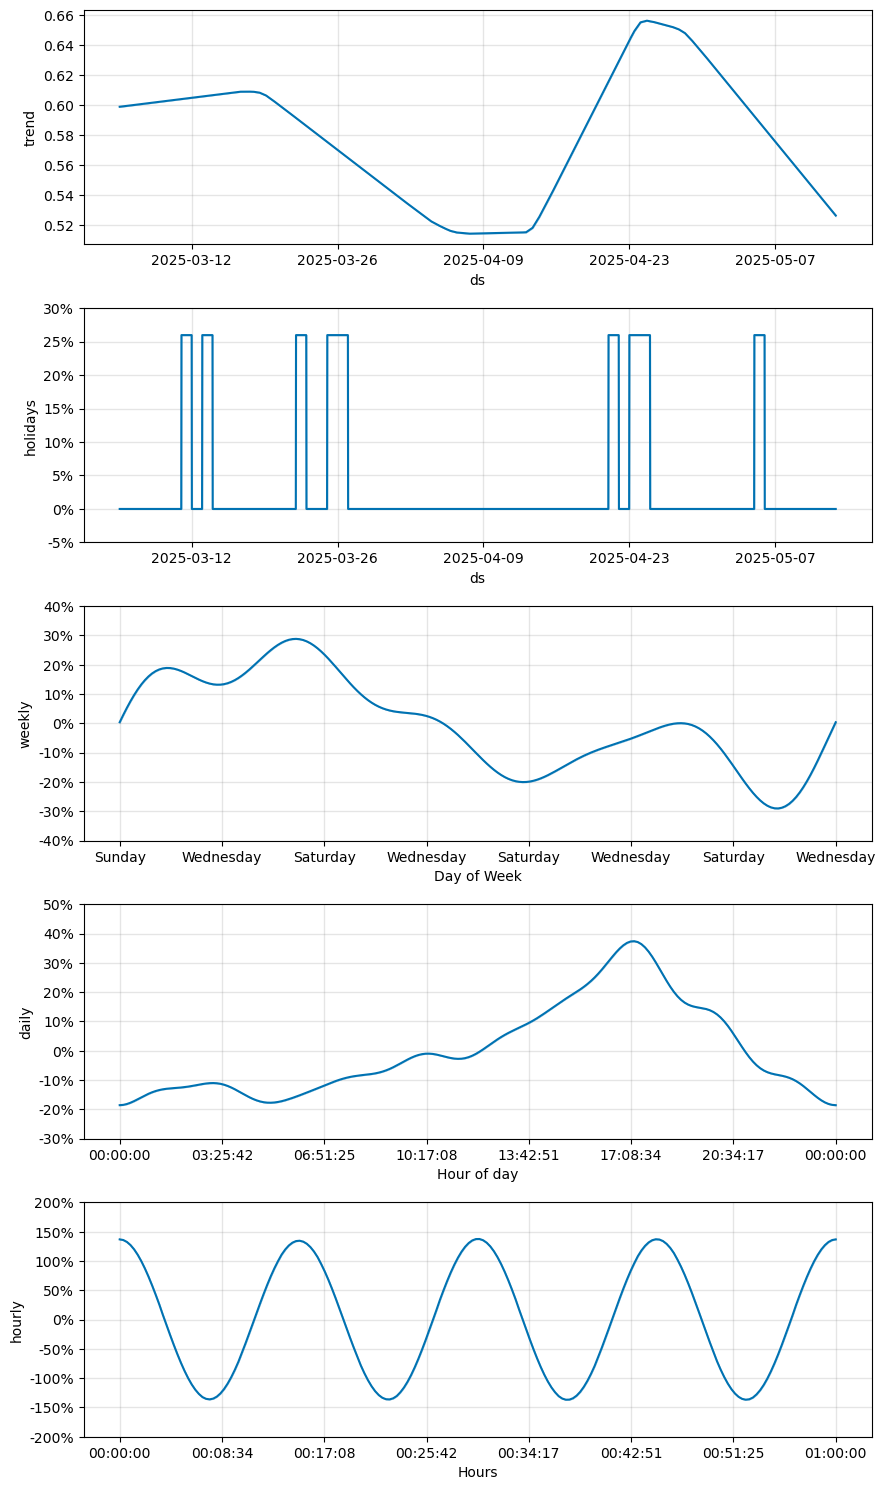

In [45]:
model_holiday = create_model_new_holiday(y_train_new)
model_holiday.fit(df_prophet_new)
future = model_holiday.make_future_dataframe(periods=96, freq='15min')
forecast = model_holiday.predict(future)
model_holiday.plot_components(forecast)

MAE: 5.4103
RMSE: 11.7847
MAPE: 0.6214


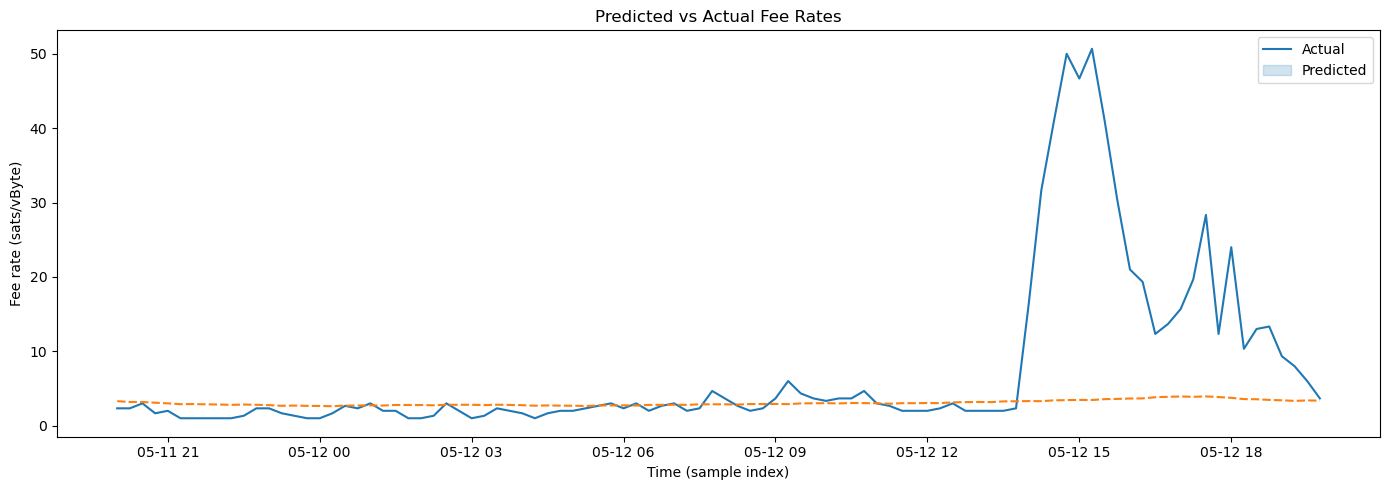

In [46]:
get_result_new(forecast,y_test_new,y_new)

20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:40 - cmdstanpy - INFO - Chain [1] done processing


Week 1
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
MAE: 1.8880
RMSE: 2.3066
MAPE: 0.5871


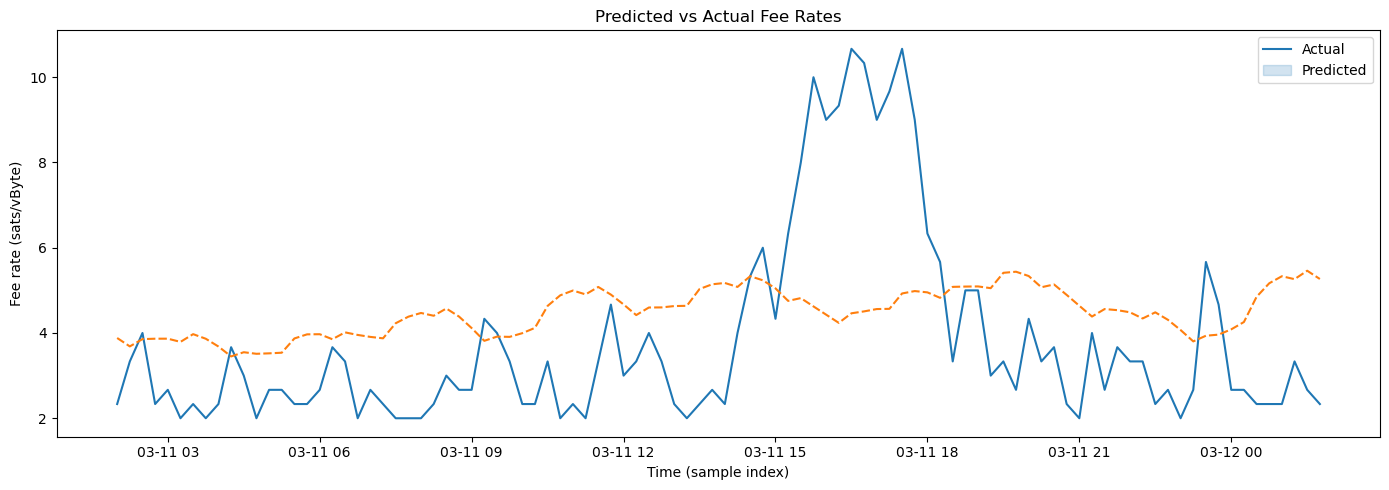

20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:40 - cmdstanpy - INFO - Chain [1] done processing


Week 2
Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
MAE: 0.7378
RMSE: 0.9674
MAPE: 0.2820


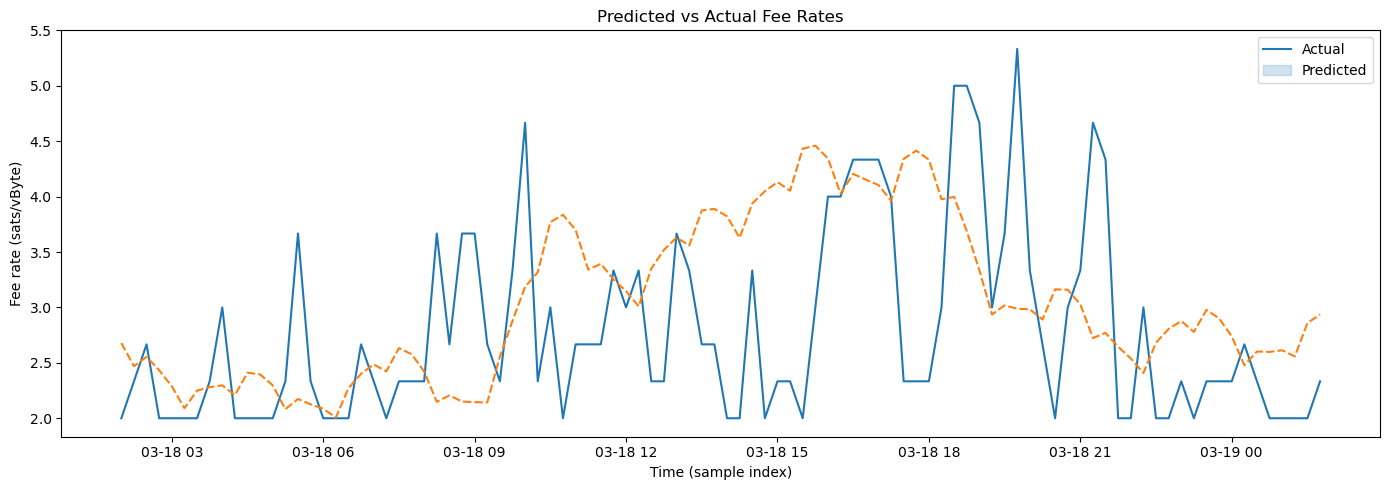

Week 3


20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 5.3958
Baseline RMSE: 10.4472
Baseline MAPE: 0.4088
MAE: 5.1153
RMSE: 9.4524
MAPE: 0.5639


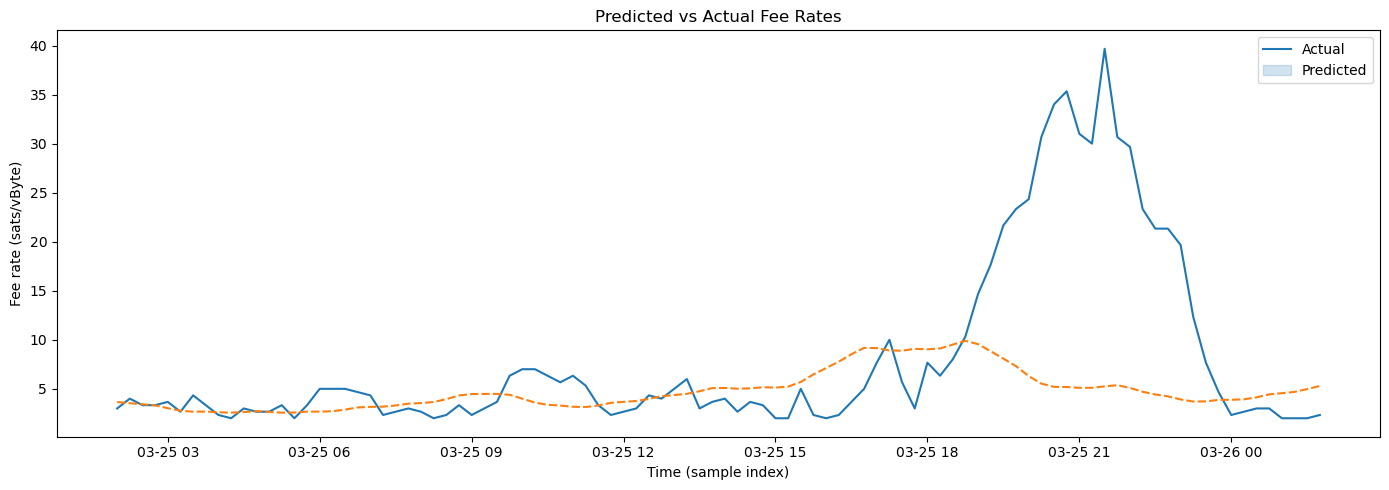

20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing


Week 4
Baseline MAE: 0.8264
Baseline RMSE: 0.9682
Baseline MAPE: 0.4462
MAE: 0.8925
RMSE: 1.1302
MAPE: 0.5052


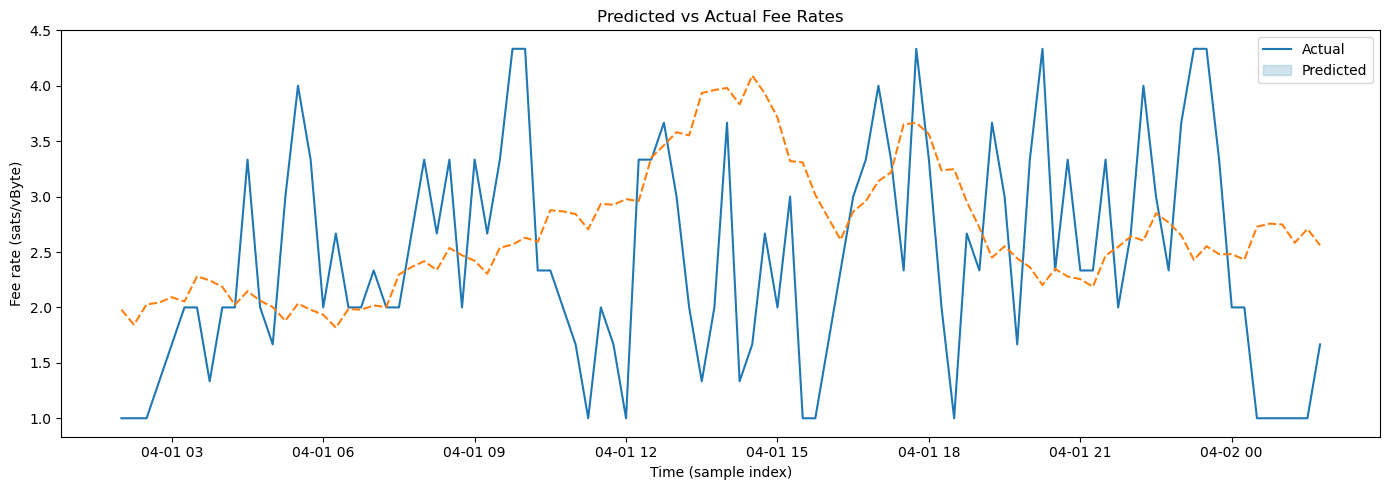

20:51:41 - cmdstanpy - INFO - Chain [1] start processing


Week 5


20:51:41 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 1.2361
Baseline RMSE: 1.6618
Baseline MAPE: 0.5004
MAE: 1.2208
RMSE: 1.6163
MAPE: 0.5500


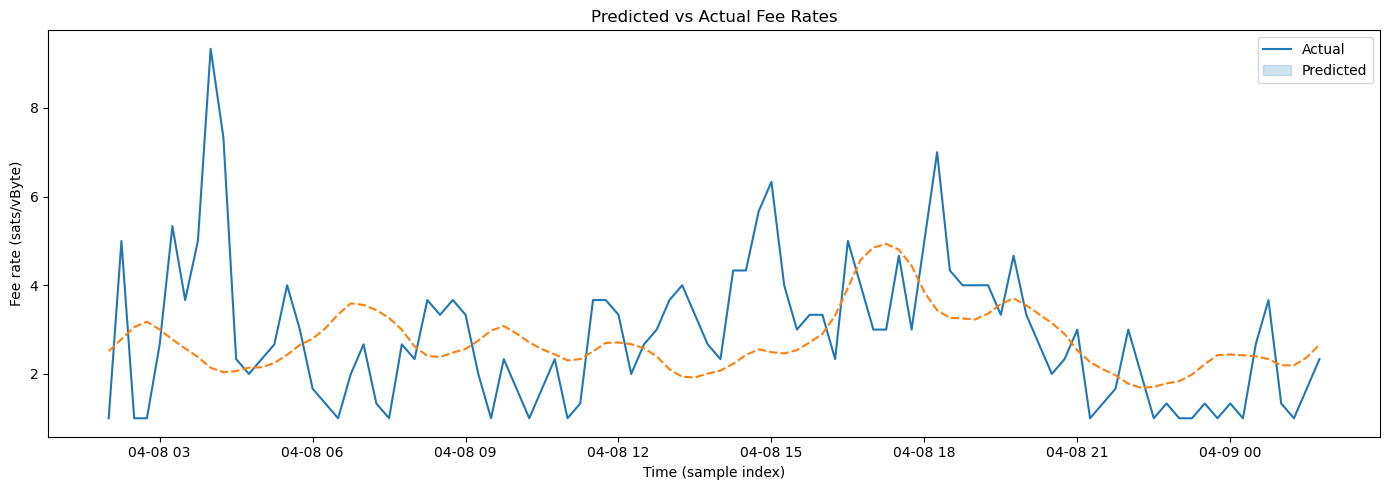

Week 6


20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 1.0174
Baseline RMSE: 1.3484
Baseline MAPE: 0.3554
MAE: 1.0362
RMSE: 1.3253
MAPE: 0.3689


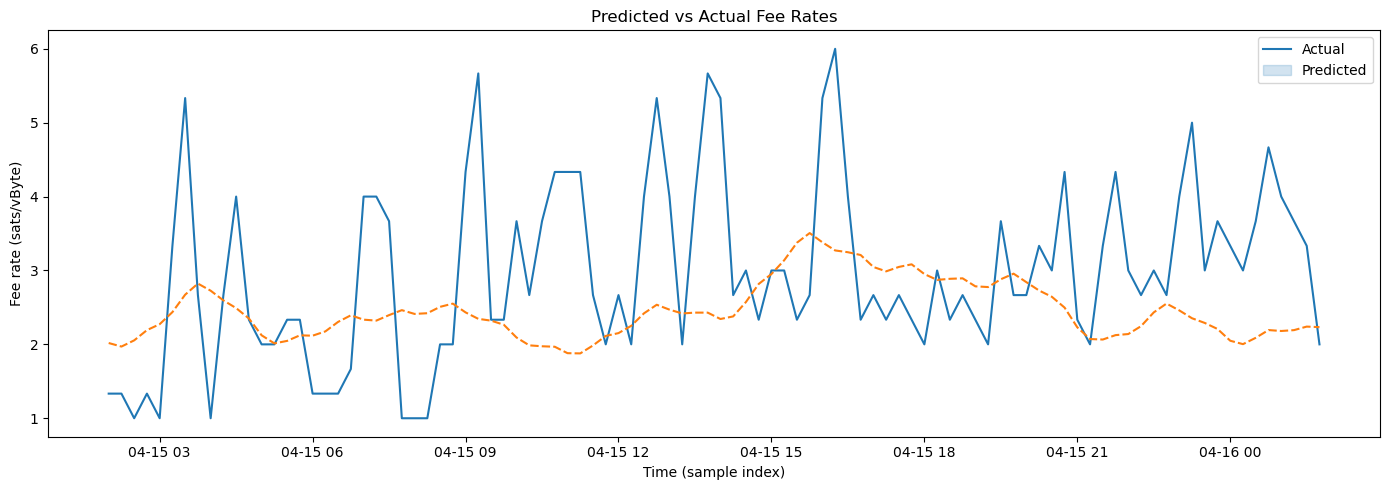

Week 7


20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 0.8715
Baseline RMSE: 1.0892
Baseline MAPE: 0.2773
MAE: 0.8620
RMSE: 1.0349
MAPE: 0.2908


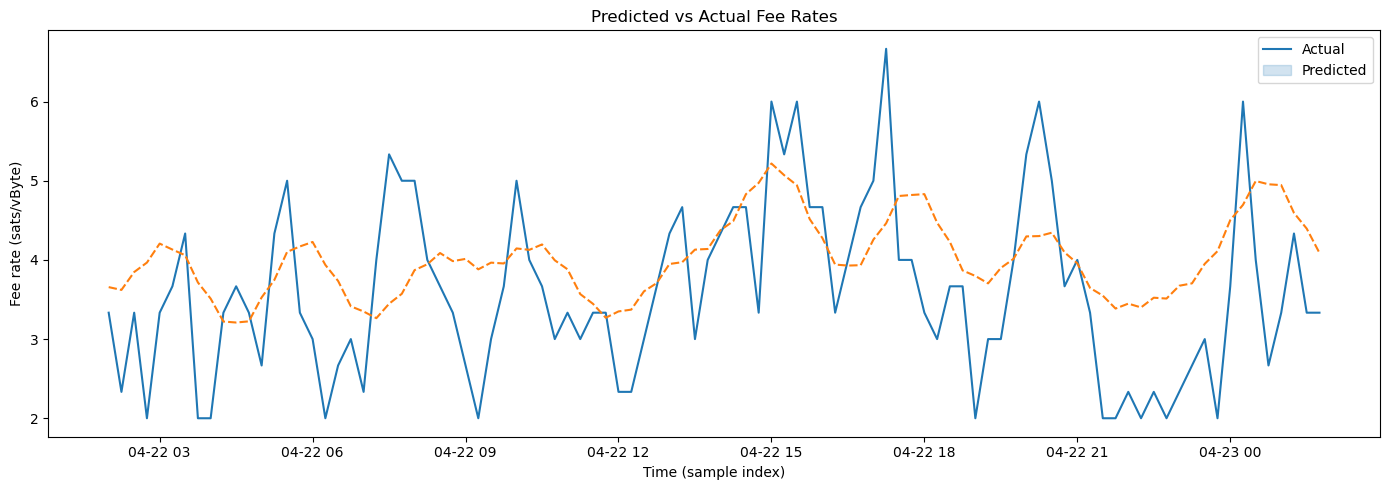

Week 8


20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 0.8438
Baseline RMSE: 1.0924
Baseline MAPE: 0.2407
MAE: 1.0086
RMSE: 1.2561
MAPE: 0.2963


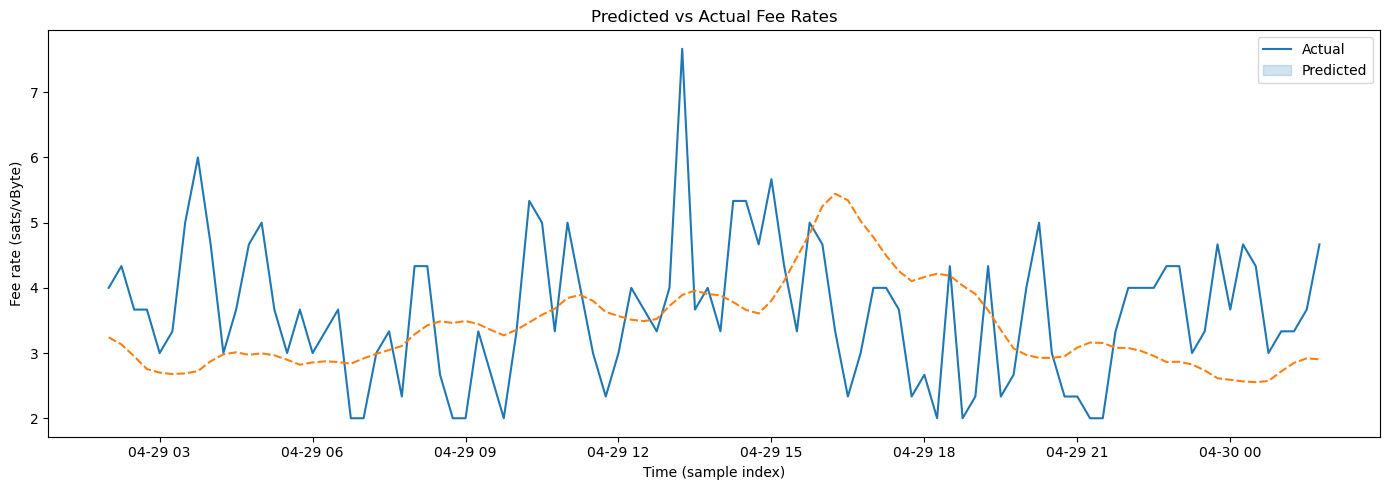

20:51:42 - cmdstanpy - INFO - Chain [1] start processing


Week 9


20:51:42 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 1.1042
Baseline RMSE: 1.4369
Baseline MAPE: 0.3126
MAE: 1.0112
RMSE: 1.3456
MAPE: 0.2792


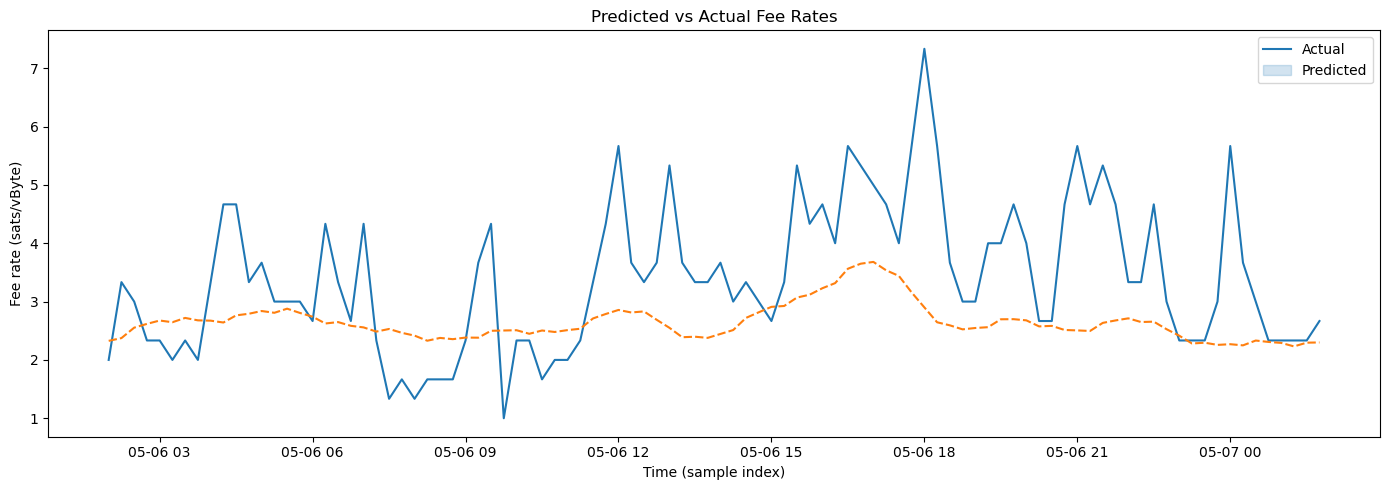

Week 10


20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing


Baseline MAE: 5.6146
Baseline RMSE: 12.0169
Baseline MAPE: 0.6775
MAE: 5.8252
RMSE: 12.5465
MAPE: 0.4990


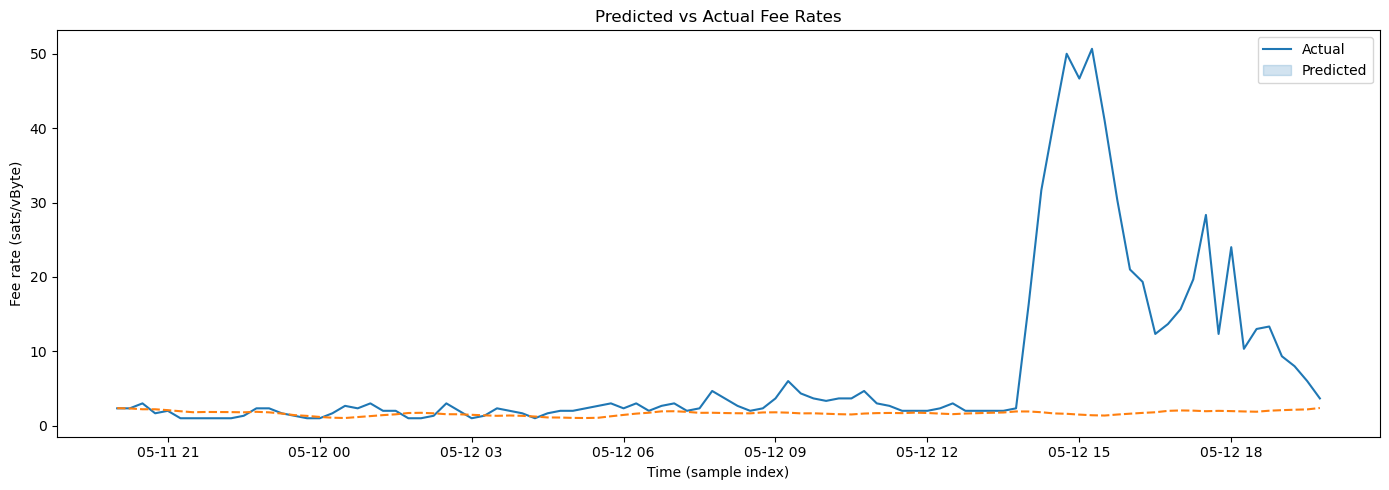



Average values: 
MAE: 1.9598
RMSE: 3.2981
MAPE: 0.4222
Baseline MAE: 1.9003
Baseline RMSE: 3.3423
Baseline MAPE: 0.3717


In [49]:
avg_mae = 0
avg_rmse = 0
avg_mape = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0

## Week 1 to Week 10
for i in range(10):
    print("Week",(i+1))
    df_sliding = df_new[0+i*7*96:7*96+i*7*96]
    y = df_sliding["recommended_fee_fastestFee"]
    split_index = len(y) - 96
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    df_prophet = y_train.reset_index()
    df_prophet = df_prophet.rename(columns={
        'timestamp': 'ds',
        'recommended_fee_fastestFee': 'y'
    })
    df_prophet['y'] = np.log1p(df_prophet['y'])

    # baseline
    y_baseline = [y_train.median()] * len(y_test)

    model = create_model_new_holiday(y_train)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=96, freq='15min')
    forecast = model.predict(future)

    y_pred_temp = forecast.iloc[-96:]
    y_pred_temp = np.expm1(y_pred_temp["yhat"])
    y_pred_temp.index =X_test.index

    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    
    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    get_result_new(forecast,y_test,y)



avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")

## Basic vs Holiday

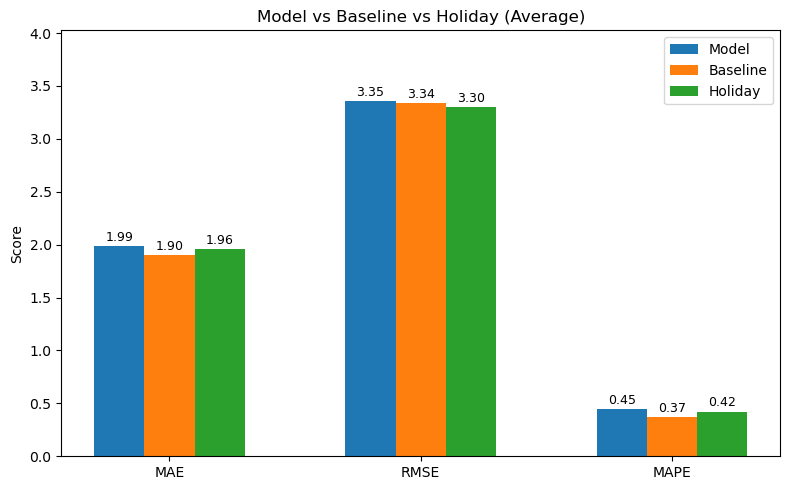

In [54]:

metrics = ['MAE', 'RMSE', 'MAPE']

holiday_scores = [1.9598, 3.2981, 0.4222]
model_scores = [1.9871, 3.3548, 0.4491]
baseline_scores = [1.9003, 3.3423, 0.3717]


x = np.arange(len(metrics))  
width = 0.2  


fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width, model_scores, width, label='Model')
bars2 = ax.bar(x, baseline_scores, width, label='Baseline')
bars3 = ax.bar(x + width, holiday_scores, width, label='Holiday')


for bar in bars1 + bars2 + bars3:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)


ax.set_ylabel('Score')
ax.set_title('Model vs Baseline vs Holiday (Average)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0, max(model_scores + baseline_scores) * 1.2)  

plt.tight_layout()
plt.show()

## Basic

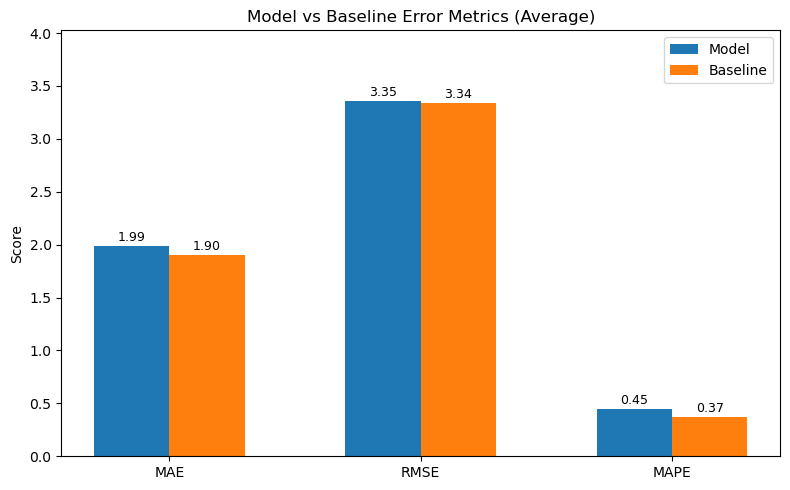

In [55]:

metrics = ['MAE', 'RMSE', 'MAPE']


model_scores = [1.9871, 3.3548, 0.4491]
baseline_scores = [1.9003, 3.3423, 0.3717]


x = np.arange(len(metrics)) 
width = 0.3 


fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, model_scores, width, label='Model')
bars2 = ax.bar(x + width/2, baseline_scores, width, label='Baseline')


for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)


ax.set_ylabel('Score')
ax.set_title('Model vs Baseline Error Metrics (Average)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0, max(model_scores + baseline_scores) * 1.2)  # 保证标签不被遮挡

plt.tight_layout()
plt.show()

In [ ]:
metrics = ['MAE', 'RMSE', 'MAPE']
weeks = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5']

model_results = [
    [2.4674, 3.5025, 0.5546],
    [0.6801, 0.9296, 0.2324],
    [5.5266, 8.2646, 1.0230],
    [0.9046, 1.1421, 0.4880],
    [1.2226, 1.6825, 0.4671]
]

baseline_results = [
    [1.1806, 1.9070, 0.2663],
    [1.3750, 1.9365, 0.2979],
    [0.6215, 0.7446, 0.2255],
    [0.8785, 1.1391, 0.4022],
    [1.2222, 1.4806, 0.7079]
]

model_results = np.array(model_results).T
baseline_results = np.array(baseline_results).T

x = np.arange(len(weeks))
width = 0.35

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    axs[i].bar(x - width/2, model_results[i], width, label='Model')
    axs[i].bar(x + width/2, baseline_results[i], width, label='Baseline')
    axs[i].set_title(f'{metric} Comparison')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(weeks)
    axs[i].legend()
    axs[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

## Basic vs External

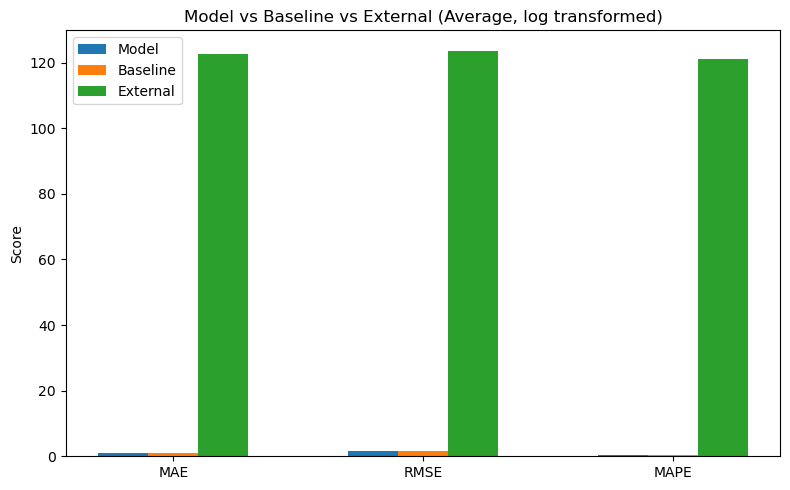

In [65]:
metrics = ['MAE', 'RMSE', 'MAPE']

external_scores = [166049078726487151429942930690138594938003348302856192.0, 498247145269555992815924419782353458718881971026526208.0, 44936075566860865944809644117288460246681542465683456.0]
model_scores = [1.9871, 3.3548, 0.4491]
baseline_scores = [1.9003, 3.3423, 0.3717]
external_scores = np.log1p(external_scores)
model_scores = np.log1p(model_scores)
baseline_scores = np.log1p(baseline_scores)

x = np.arange(len(metrics))  
width = 0.2  


fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width, model_scores, width, label='Model')
bars2 = ax.bar(x, baseline_scores, width, label='Baseline')
bars3 = ax.bar(x + width, external_scores, width, label='External')


# for bar in bars1 + bars2 + bars3:
#     yval = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)


ax.set_ylabel('Score')
ax.set_title('Model vs Baseline vs External (Average, log transformed)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
#plt.ylim(0, max(model_scores + baseline_scores) * 1.2)  

plt.tight_layout()
plt.show()